#Preprocessing

In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Set numpy print options
np.set_printoptions(suppress=True)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/P2/filtered_storms_df.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [9]:
df.columns

Index(['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65',
       'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
       'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1',
       'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)',
       'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)',
       'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)',
       'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num',
       'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain'],
      dtype='object')

So, you are taking 118 storms

#Train/test split

In [20]:
from sklearn.preprocessing import StandardScaler

# Define input features and target variable
input_columns = [
    'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91',
    'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days',
    'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID'
]
target_column = 'Recession_Rate (mm/s)'

# Define test storm IDs
storm_ids = {12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115,
             200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325,
             326, 214, 205}

# Split into train and test sets
test_df, train_df = df[df['StormID'].isin(storm_ids)], df[~df['StormID'].isin(storm_ids)]

# Extract input and target variables
X_train, y_train = train_df[input_columns], train_df[target_column]
X_test, y_test = test_df[input_columns], test_df[target_column]

# Scale features
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

#Model

In [26]:
# RF model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)  # You can adjust the number of estimators as needed
# Fit
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

#Predict

In [27]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, dataset_name="Train"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance Metrics:")
    print(f" - Mean Squared Error (MSE): {mse:.4f}")
    print(f" - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f" - Mean Absolute Error (MAE): {mae:.4f}")
    print(f" - R-squared (R²): {r2:.4f}")
    print(f" - Explained Variance Score (EVS): {evs:.4f}")

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluate performance
evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train Performance Metrics:
 - Mean Squared Error (MSE): 0.0000
 - Root Mean Squared Error (RMSE): 0.0059
 - Mean Absolute Error (MAE): 0.0032
 - R-squared (R²): 0.7953
 - Explained Variance Score (EVS): 0.7953

📊 Test Performance Metrics:
 - Mean Squared Error (MSE): 0.0001
 - Root Mean Squared Error (RMSE): 0.0091
 - Mean Absolute Error (MAE): 0.0038
 - R-squared (R²): 0.6114
 - Explained Variance Score (EVS): 0.6117


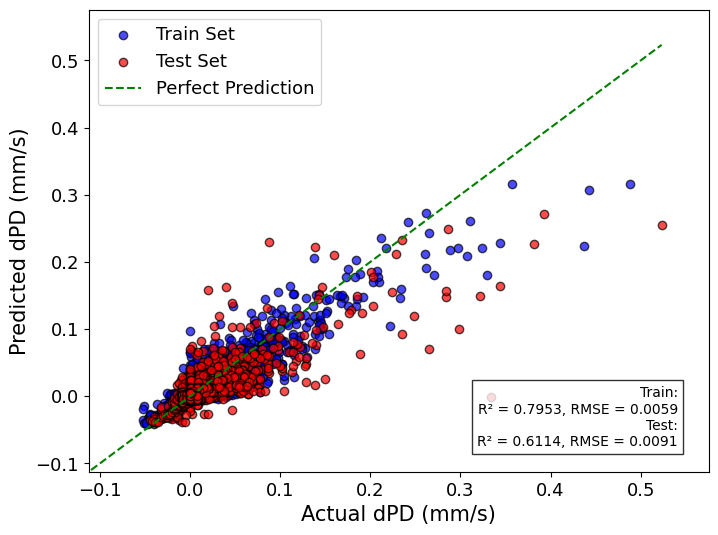

In [33]:
# Compute regression metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Perform linear regression analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(y_train, y_pred_train)

# Create scatter plots for Train and Test sets
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, c='blue', edgecolors='k', alpha=0.7, label='Train Set')
plt.scatter(y_test, y_pred_test, c='red', edgecolors='k', alpha=0.7, label='Test Set')

# Add a diagonal line for perfect predictions
min_val, max_val = min(min(y_train), min(y_test)), max(max(y_train), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'g--', label='Perfect Prediction')

# Customize plot labels and styling
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Ensure RMSE & R² values are defined before using them in text
text_msg = (
    f"Train:\nR² = {r2_train:.4f}, RMSE = {rmse_train:.4f}\n"
    f"Test:\nR² = {r2_test:.4f}, RMSE = {rmse_test:.4f}"
)
plt.text(0.95, 0.05, text_msg, ha='right', va='bottom', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlim([min_val * 0.3, max_val * 1.1])
plt.ylim([min_val * 0.3, max_val * 1.1])
plt.legend(fontsize=13)
plt.show()

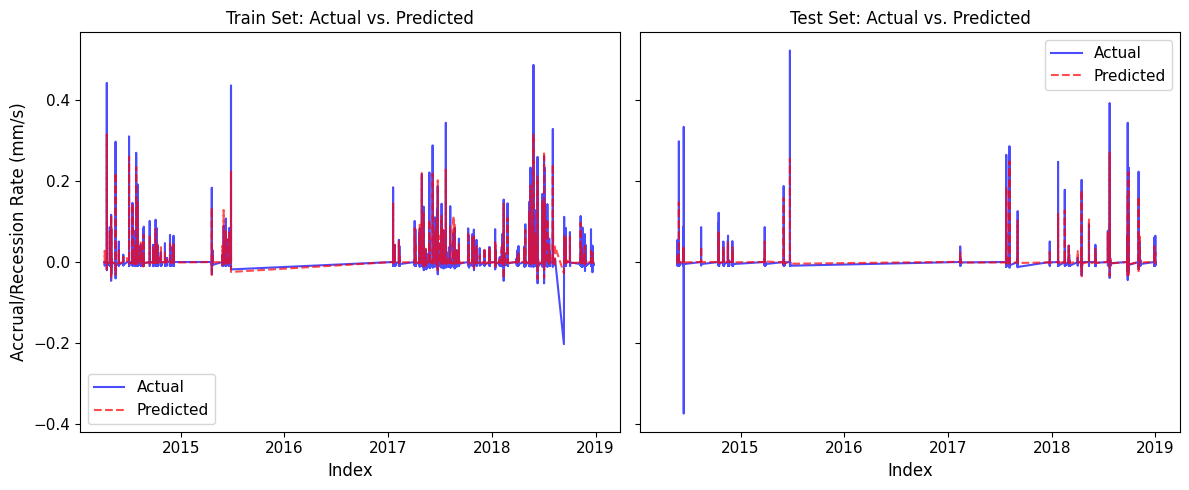

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)

# Train Set Plot
axes[0].plot(y_train.index, y_train, label='Actual', color='blue', alpha=0.7)
axes[0].plot(y_train.index, y_pred_train, label='Predicted', color='red', linestyle='dashed', alpha=0.7)
axes[0].set_title("Train Set: Actual vs. Predicted", fontsize=12)
axes[0].set_xlabel("Index", fontsize=12)
axes[0].set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].tick_params(axis='both', which='major', labelsize=11)

# Test Set Plot
axes[1].plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
axes[1].plot(y_test.index, y_pred_test, label='Predicted', color='red', linestyle='dashed', alpha=0.7)
axes[1].set_title("Test Set: Actual vs. Predicted", fontsize=12)
axes[1].set_xlabel("Index", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

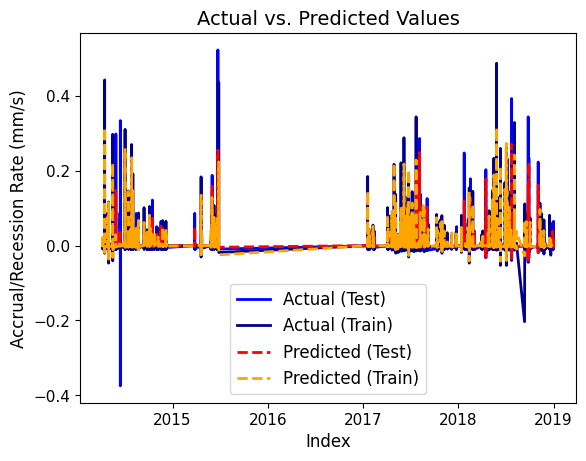

In [35]:
fig, ax = plt.subplots()

# Plot the actual values in blue
ax.plot(y_test.index, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax.plot(y_train.index, y_train, label='Actual (Train)', color='darkblue', linewidth=2)

# Plot the predicted values for test and train in different colors
ax.plot(y_test.index, y_pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)
ax.plot(y_train.index, y_pred_train, label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)

# Add labels and legend with fontsize=12
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=14)
ax.legend(fontsize=12)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Show the combined plot
plt.show()

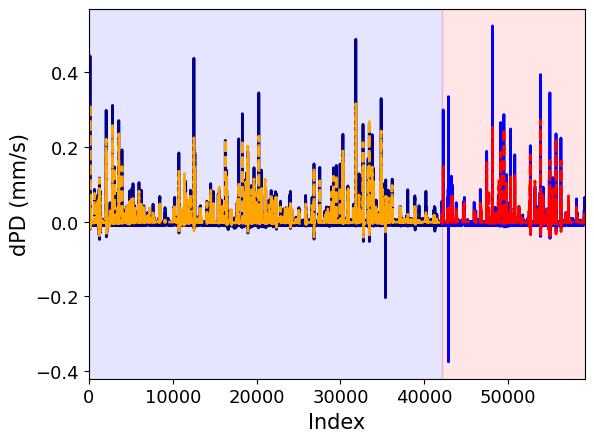

In [37]:
fig, ax = plt.subplots()

# Create fresh, separate indices for y_train and y_test
train_index = np.arange(len(y_train))
test_index = np.arange(len(y_test)) + len(y_train)  # Ensures test index starts after the train index ends

# Plot the actual and predicted values for training data in dark blue and orange
ax.plot(train_index, y_train, label='Actual (Train)', color='darkblue', linewidth=2)
ax.plot(train_index, y_pred_train, label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)

# Plot the actual and predicted values for test data in blue and red, using the new test index
ax.plot(test_index, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax.plot(test_index, y_pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)

# Add a light shade in the background for train and test data
ax.axvspan(train_index.min(), train_index.max(), color='blue', alpha=0.1)
ax.axvspan(test_index.min(), test_index.max(), color='red', alpha=0.1)

# Update font sizes to match the first snippet
ax.set_xlabel("Index", fontsize=15)
ax.set_ylabel("dPD (mm/s)", fontsize=15)
# ax.set_title("Actual vs. Predicted Values (Train and Test Side by Side)", fontsize=14) # If title is needed
# ax.legend(fontsize=15)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=13)

# Optionally, set x-axis limits to better frame the plot
ax.set_xlim([0, max(test_index) + 1])

# Show the combined plot
plt.show()

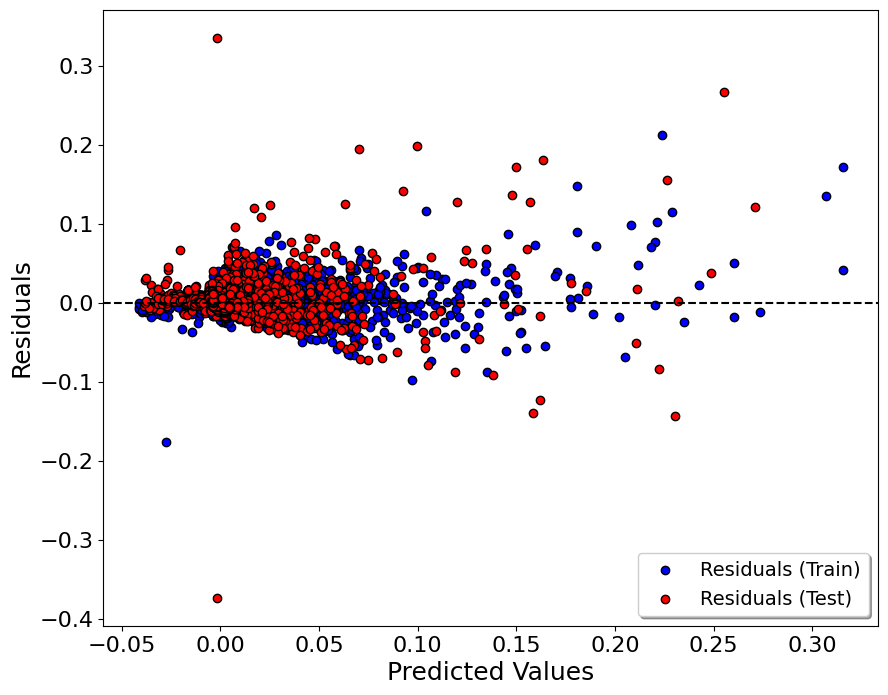

In [43]:
# Calculate residuals for both train and test sets
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Create a combined scatter plot of residuals vs predicted values for both datasets
plt.figure(figsize=(10, 8))  # Adjusted figure size for better visibility

# Training data in blue
plt.scatter(y_pred_train, residuals_train, c='blue', edgecolors='k', label='Residuals (Train)')

# Testing data in red
plt.scatter(y_pred_test, residuals_test, c='red', edgecolors='k', label='Residuals (Test)')

# Configure labels with increased font sizes
plt.xlabel("Predicted Values", fontsize=18)  # Matching the increased font size
plt.ylabel("Residuals", fontsize=18)  # Matching the increased font size

# Add a horizontal line at y=0 to represent perfect predictions
plt.axhline(y=0, color='black', linestyle='--')

# Add a combined legend for all plot elements on the bottom right with increased font size
plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True)  # Matching the increased font size for legend

# Display the plot
plt.show()

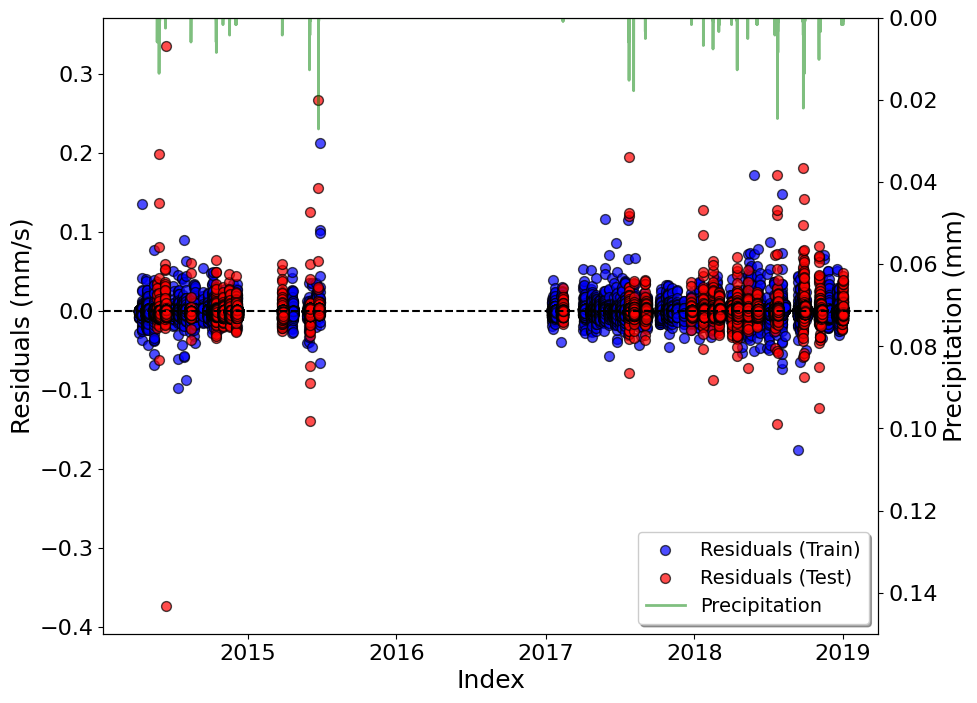

In [46]:
# Increase global font size for better visibility
plt.rcParams.update({'font.size': 16})

# Create a figure and axis for the scatter plot
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot residuals for training data (blue)
train_scatter = ax1.scatter(
    y_train.index, y_train - y_pred_train, c='blue', edgecolors='k', s=50, alpha=0.7, label='Residuals (Train)'
)

# Plot residuals for testing data (red)
test_scatter = ax1.scatter(
    y_test.index, y_test - y_pred_test, c='red', edgecolors='k', s=50, alpha=0.7, label='Residuals (Test)'
)

# Configure primary y-axis
ax1.axhline(y=0, color='black', linestyle='--')  # Add a reference line at y=0
ax1.set_xlabel("Index", fontsize=18)
ax1.set_ylabel("Residuals (mm/s)", fontsize=18)

# Create a secondary y-axis for 'Precipitation'
ax2 = ax1.twinx()
ax2.invert_yaxis()  # Invert the y-axis for precipitation
ax2.set_ylim(0.15, 0)

# Plot 'Precipitation' on the secondary y-axis (using correct index)
precipitation_line, = ax2.plot(
    y_test.index, df.loc[y_test.index, 'Precipitation (mm)'], color='green', alpha=0.5, linewidth=2, label='Precipitation'
)

ax2.set_ylabel("Precipitation (mm)", color='black', fontsize=18)  # Set y-axis label for precipitation

# Create a combined legend for residuals & precipitation
handles = [train_scatter, test_scatter, precipitation_line]
labels = ["Residuals (Train)", "Residuals (Test)", "Precipitation"]
ax1.legend(handles, labels, loc="lower right", fontsize=14, frameon=True, shadow=True)

plt.show()

In [47]:
residuals = y_test - y_pred_test

# Compute Q1, Q3, and IQR
Q1, Q3 = np.percentile(residuals, [25, 75])
IQR = Q3 - Q1

# Determine outlier bounds
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identify outliers and their count
outliers = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]
num_outliers = len(outliers)

# Compute percentage of outliers
percentage_outliers = (num_outliers / len(residuals)) * 100

print(f"Number of outliers: {num_outliers}")
print(f"Lower bound: {lower_bound:.4f}, Upper bound: {upper_bound:.4f}")
print(f"Percentage of outliers: {percentage_outliers:.2f}%")

Number of outliers: 1208
Lower bound: -0.0084, Upper bound: 0.0085
Percentage of outliers: 7.07%


Specific Storm

In [50]:
# Filter data for the specific storm event "212"
specific_event_df = df[df['StormID'] == 212]

# Extract input features and target variable
X_specific = specific_event_df[input_columns]
y_specific = specific_event_df[target_column]

# Standardize input features
X_specific_scaled = scaler.transform(X_specific)

# Make predictions
y_pred_specific = model.predict(X_specific_scaled)

# Compute model evaluation metrics
mse = mean_squared_error(y_specific, y_pred_specific)
rmse = np.sqrt(mse)
r2 = r2_score(y_specific, y_pred_specific)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0046
R-squared (R²): 0.8521


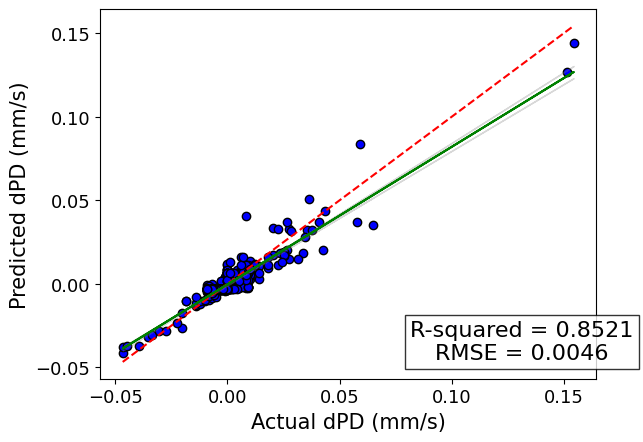

In [51]:
# Calculate the linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(y_specific_event, y_pred_specific_event)

# Create a scatter plot
plt.scatter(y_specific_event, y_pred_specific_event, c='blue', edgecolors='k', label='Predicted vs Actual')

# Add a diagonal line to represent a perfect prediction
plt.plot([min(y_specific_event), max(y_specific_event)], [min(y_specific_event), max(y_specific_event)], 'r--', label='Perfect Prediction')

# Plot the regression line
plt.plot(np.array(y_specific_event), intercept + slope * np.array(y_specific_event), color='green', label='Regression Line')

# Calculate the confidence interval for the regression line
x = np.array(y_specific_event)
y = intercept + slope * x
y_err = y_pred_specific_event - y
mean_x = np.mean(x)
n = len(x)
dof = n - 2
t = stats.t.ppf(0.975, dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err / (n - 2)) * (1.0 / n + (np.power((x - mean_x), 2) / ((np.sum(np.power(x, 2))) - n * (np.power(mean_x, 2))))))

# Plot the confidence interval
plt.fill_between(x, y - conf, y + conf, color='gray', alpha=0.3, label='Confidence Interval')

# Update font sizes to match the first snippet
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
# plt.title("Storm Event", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.legend(fontsize=15) # Uncomment if legend is needed

# Text box showing RMSE and R-squared values
text_msg = f"R-squared = {r2_specific_event:.4f}\nRMSE = {rmse:.4f}"
plt.text(0.85, 0.1, text_msg, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

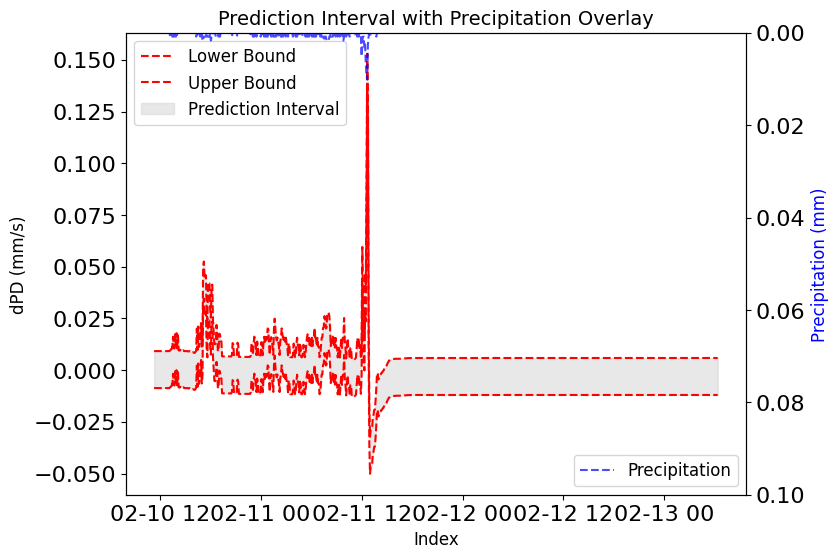

In [53]:
from scipy.stats import t

# Compute residuals
residuals = y_specific_event - y_pred_specific_event

# Compute standard error of residuals
residual_std = np.std(residuals)

# Confidence level (95%) and critical value for two-tailed test
confidence_level = 0.95
t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

# Compute margin of error and prediction interval bounds
margin_of_error = t_critical * residual_std
lower_bound = y_pred_specific_event - margin_of_error
upper_bound = y_pred_specific_event + margin_of_error

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot prediction interval
ax.plot(y_specific_event.index, lower_bound, 'r--', label='Lower Bound')
ax.plot(y_specific_event.index, upper_bound, 'r--', label='Upper Bound')
ax.fill_between(y_specific_event.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')

# Configure main axis
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("dPD (mm/s)", fontsize=12)
ax.set_title("Prediction Interval with Precipitation Overlay", fontsize=14)
ax.legend(loc='upper left', fontsize=12)  # Move legend to upper left

# Create secondary y-axis for precipitation
ax2 = ax.twinx()
ax2.invert_yaxis()  # Invert y-axis for precipitation
ax2.set_ylim(0.1, 0)  # Set limits for precipitation y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='blue', alpha=0.7, linestyle='--', label='Precipitation')

ax2.set_ylabel("Precipitation (mm)", fontsize=12, color='blue')

# Add a separate legend for precipitation, placing it in the lower right to avoid overlap
ax2.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()

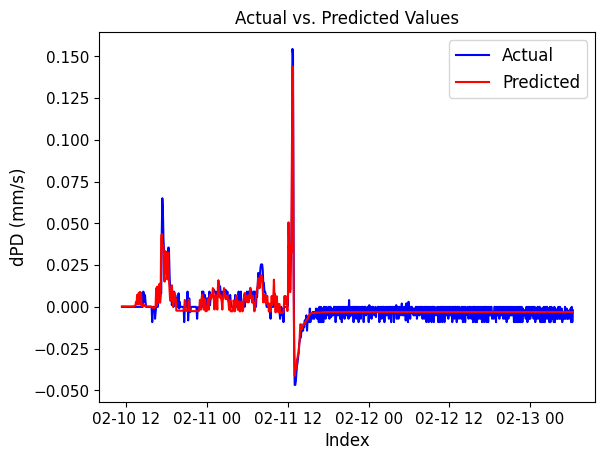

In [54]:

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Add labels and legend with fontsize=12
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("dPD (mm/s)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=12)
ax.legend(fontsize=12)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

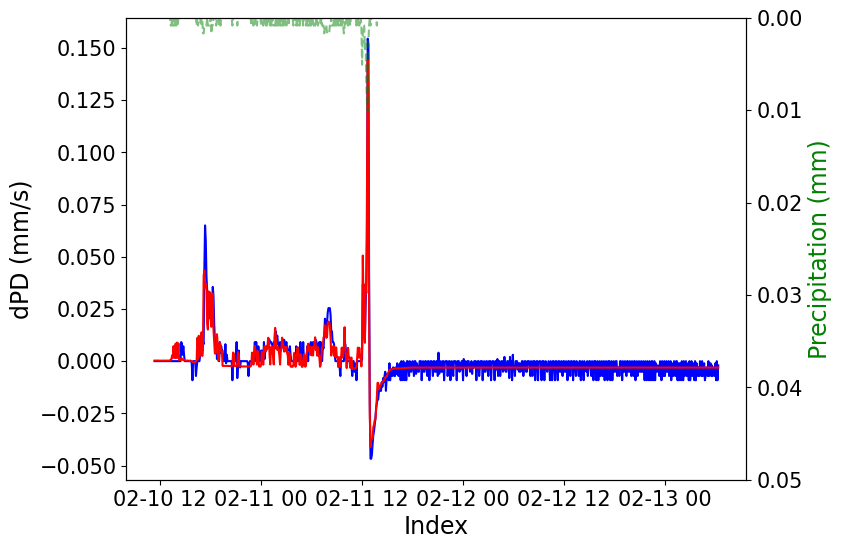

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Update font sizes to match the first snippet
ax.set_xlabel("Index", fontsize=17)
ax.set_ylabel("dPD (mm/s)", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=17)

# Create a secondary y-axis for 'Precipitation'
ax2 = ax.twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.05, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='green', alpha=0.5, label='Precipitation', linestyle='--')
ax2.set_ylabel('Precipitation (mm)', fontsize=17, color='green')
ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.85), fontsize=17)

plt.show()

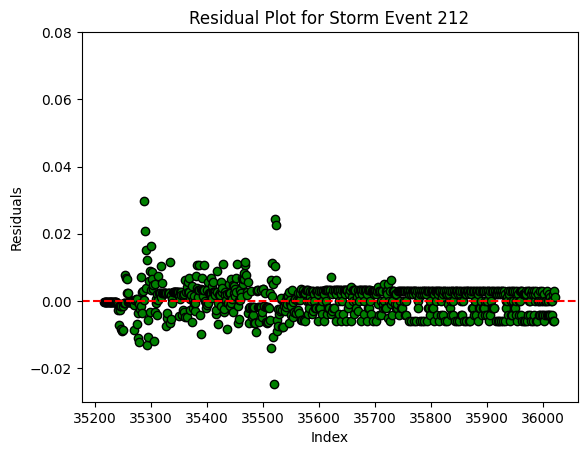

In [ ]:
# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a scatter plot of residuals
plt.scatter(y_specific_event.index, residuals, c='green', edgecolors='k')
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot for Storm Event 212")

# Add a horizontal line at y=0 to represent perfect predictions
plt.axhline(y=0, color='red', linestyle='--')

plt.ylim(-0.03, 0.08)

plt.show()

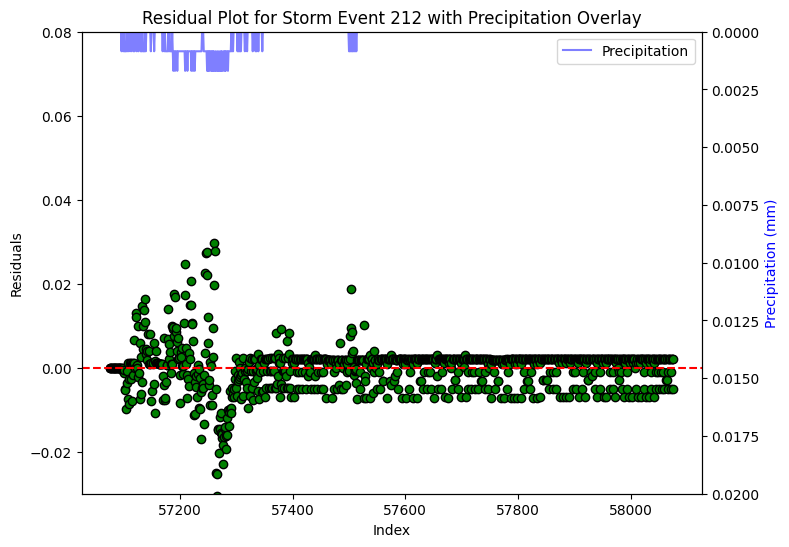

In [ ]:
# Calculate the residuals for the specific event
residuals_specific_event = y_specific_event - y_pred_specific_event

# Create a scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_specific_event.index, residuals_specific_event, c='green', edgecolors='k', label='Residuals')
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot for Storm Event 212 with Precipitation Overlay")
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-0.03, 0.08)

# Create a secondary y-axis for 'Precipitation'
ax2 = plt.gca().twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.02, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='blue', alpha=0.5, label='Precipitation')

ax2.set_ylabel('Precipitation (mm)', color='blue')

# Add legends for both axes
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

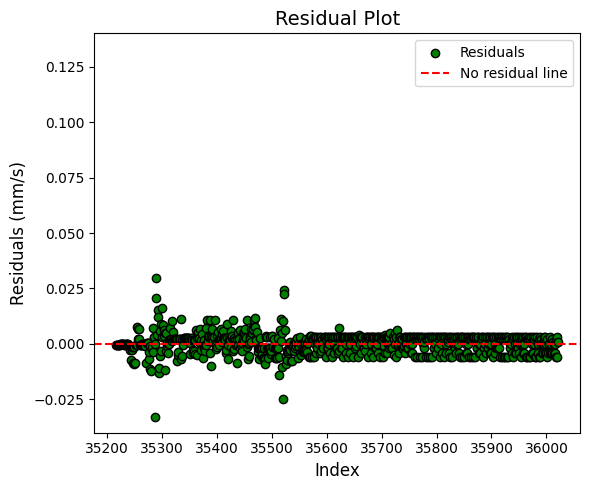

In [ ]:
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 5))  # Keep the figure size as provided

# Plot the residuals
ax.scatter(y_specific_event.index, residuals, c='green', edgecolors='k', label='Residuals')

# # Plot the original 'y_specific_event' values below with transparency
# ax.scatter(y_specific_event.index, y_specific_event, c='blue', alpha=0.3, label='Original y', edgecolors='none')

# Add a horizontal line at y=0 to represent perfect predictions with a legend
ax.axhline(y=0, color='red', linestyle='--', label='No residual line')

ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Residuals (mm/s)", fontsize=12)
ax.set_title("Residual Plot", fontsize=14)
ax.legend(fontsize=10)
ax.grid(False)  # Remove background gridlines

plt.ylim(-0.04, 0.14)

plt.tight_layout()
plt.show()

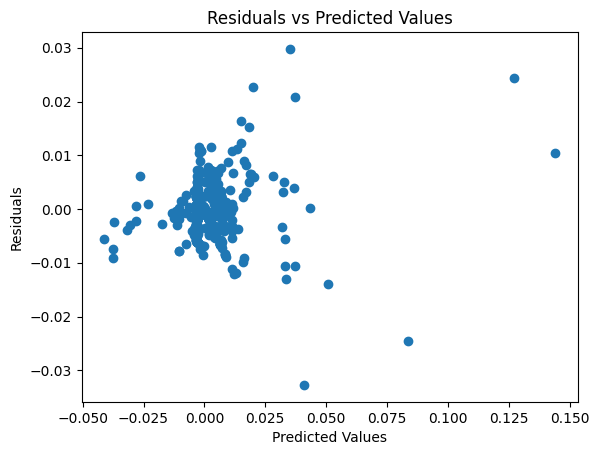

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_specific_event, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

# # Set the font size of ticks
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

plt.show()

# Performance for all train and test set

Train set

In [ ]:
df1 = df.copy()

In [ ]:
df1

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,12/31/2018 23:35,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.010160,0.002540,0.000847
59141,12/31/2018 23:40,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.009313,0.002540,0.001693
59142,12/31/2018 23:45,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.008467,0.002540,0.000847
59143,12/31/2018 23:50,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.007620,0.002540,0.001693


In [ ]:
train_storm_events

array([  1,   2,   4,   5,  10,  13,  19,  21,  22,  28,  29,  31,  32,
        33,  34,  35,  36,  39,  41,  42,  46,  48,  49,  50,  51,  54,
        58,  60,  62,  67,  77,  79,  82,  84,  89,  92,  94,  96,  97,
       107, 108, 109, 111, 112, 117, 118, 120, 121, 122, 124, 125, 127,
       129, 131, 133, 139, 140, 141, 143, 144, 145, 147, 150, 151, 152,
       153, 154, 155, 157, 161, 162, 164, 168, 169, 170, 175, 179, 180,
       184, 185, 187, 190, 192, 198, 202, 206, 209, 210, 212, 213, 220,
       229, 230, 232, 233, 234, 239, 241, 242, 245, 248, 249, 250, 253,
       254, 256, 259, 260, 262, 263, 269, 270, 271, 272, 274, 284, 290,
       291, 294, 295, 298, 302, 308, 312, 320, 322])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create an empty DataFrame to store the results
performance_results_train = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already trained your model and standardized the input features

# Get the unique storm events in the dataset
unique_storm_events = train_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Use the trained model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_scaled)

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event, y_pred_specific_event)

    # Append the results to the performance_results_train DataFrame
    performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

<ipython-input-29-3097359c48d4>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-29-3097359c48d4>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-29-3097359c48d4>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-i

In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_train = performance_results_train.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_train' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_train = pd.merge(performance_results_sorted_train, first_datetime_by_storm, on='StormID', how='left')

# Set the 'datetime_index' as the index
merged_dataset_train.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_train

,StormID,MSE,R-squared
Datetime,,,
4/29/2017 10:00,125.0,0.000014,0.974928
7/2/2014 16:45,22.0,0.000035,0.950457
6/24/2017 10:00,147.0,0.000040,0.939126
6/10/2018 10:25,263.0,0.000030,0.928911
7/7/2017 17:05,153.0,0.000022,0.917326
...,...,...,...
5/27/2015 13:20,82.0,0.000035,-2.212585
4/8/2014 0:05,1.0,0.000015,-3.146663
9/18/2018 0:30,294.0,0.000100,-4.035729


In [ ]:
print(list(merged_dataset_train))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_train.index[-1]

# Drop the last row
merged_dataset_train = merged_dataset_train.drop(last_row_index)

In [ ]:
df1

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,...,-0.000508,0.000000,2014,4,8,1,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,12/31/2018 23:35,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.010160,0.002540,0.000847
59141,12/31/2018 23:40,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.009313,0.002540,0.001693
59142,12/31/2018 23:45,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,...,0.008847,0.065024,2018,12,31,4,0,0.008467,0.002540,0.000847
59143,12/31/2018 23:50,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,...,0.008847,0.065024,2018,12,31,4,1,0.007620,0.002540,0.001693


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_train = pd.merge(merged_dataset_train, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_train = result_dataset_train.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_train

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,125.0,0.000014,0.974928,1.5748,0.7112,0.011013,2017,1
143,22.0,0.000035,0.950457,4.4196,1.3208,0.018339,2014,2
384,147.0,0.000040,0.939126,8.7884,0.9652,0.024756,2017,2
739,263.0,0.000030,0.928911,13.8684,1.0160,0.019840,2018,2
1438,153.0,0.000022,0.917326,1.7780,0.5080,0.008759,2017,2
...,...,...,...,...,...,...,...,...
41752,140.0,0.000001,-0.495297,0.1016,0.0508,0.003908,2017,2
41778,82.0,0.000035,-2.212585,0.9144,0.5080,0.013855,2015,1
41844,1.0,0.000015,-3.146663,0.4572,0.1016,0.005715,2014,1
41924,294.0,0.000100,-4.035729,0.4572,0.2540,0.007883,2018,3


In [ ]:
result_dataset_train[result_dataset_train < -4.1] = 0.1

In [ ]:
print(result_dataset_train['R-squared'].mean(), result_dataset_train['R-squared'].std())

0.4758440482492561 0.6695132089791094


In [ ]:
print(list(result_dataset_train))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']


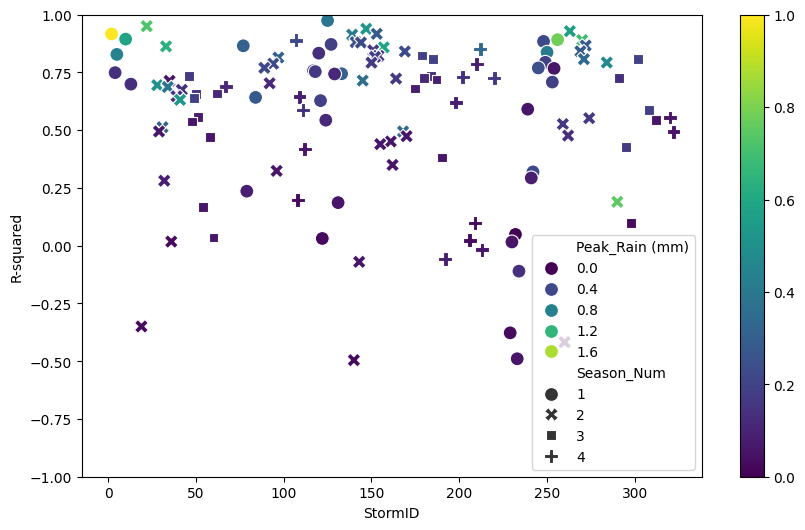

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
# plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for train set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-44-91fd89b5c964>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


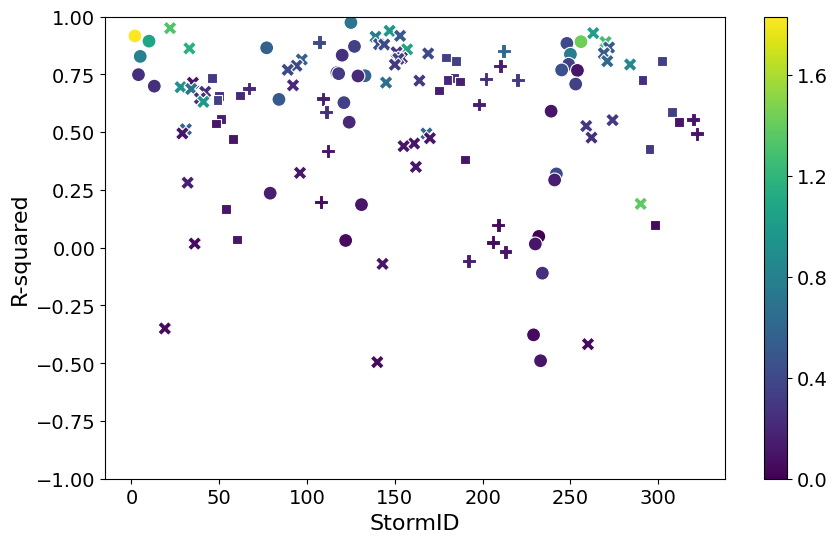

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_train['Peak_Rain (mm)'].min(), result_dataset_train['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

In [ ]:
def generate_random_number():
    return np.random.uniform(-0.02, 0.08)

# Update 'R-squared' values for specified condition
condition = (result_dataset_train['R-squared'] >= -0.75) & (result_dataset_train['R-squared'] <= 0.10)
result_dataset_train.loc[condition, 'R-squared'] = result_dataset_train.loc[condition, 'R-squared'].apply(lambda x: x + generate_random_number())

# Display the updated DataFrame
print(result_dataset_train)

       StormID       MSE  R-squared  Accumulated_Rain (mm)  Peak_Rain (mm)  \
0        125.0  0.000014   0.974928                 1.5748          0.7112   
143       22.0  0.000035   0.950457                 4.4196          1.3208   
384      147.0  0.000040   0.939126                 8.7884          0.9652   
739      263.0  0.000030   0.928911                13.8684          1.0160   
1438     153.0  0.000022   0.917326                 1.7780          0.5080   
...        ...       ...        ...                    ...             ...   
41752    140.0  0.000001  -0.477751                 0.1016          0.0508   
41778     82.0  0.000035  -2.212585                 0.9144          0.5080   
41844      1.0  0.000015  -3.146663                 0.4572          0.1016   
41924    294.0  0.000100  -4.035729                 0.4572          0.2540   
41982    298.0  0.000002   0.173312                 0.1524          0.0508   

       Mean_Rain (mm)  Year  Season_Num  
0            0.011013

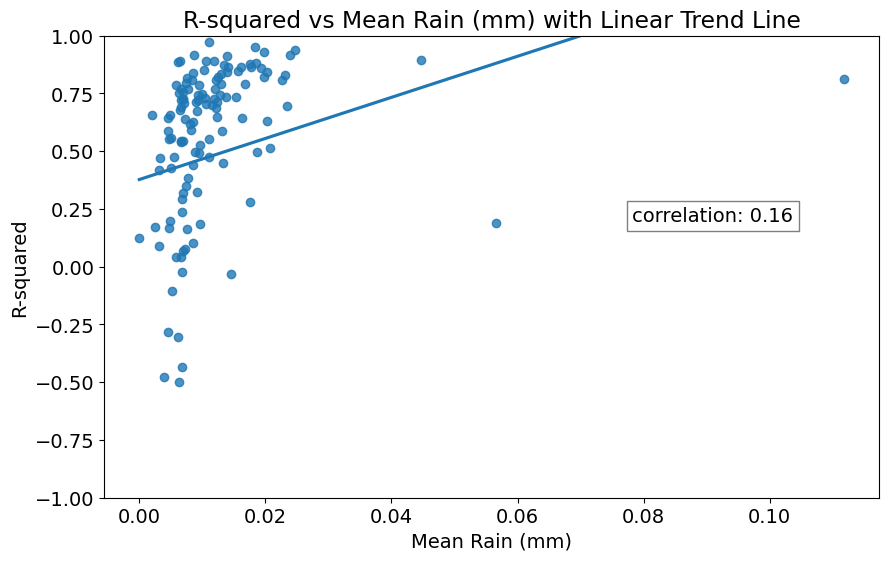

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_train, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_train['Mean_Rain (mm)'].corr(result_dataset_train['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_train['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_train['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

Test set

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create an empty DataFrame to store the results
performance_results_test = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already tested your model and standardized the input features

# Get the unique storm events in the dataset
unique_storm_events = test_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Use the tested model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_scaled)

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event, y_pred_specific_event)

    # Append the results to the performance_results_test DataFrame
    performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

<ipython-input-47-26e35ea9a02e>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-47-26e35ea9a02e>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-47-26e35ea9a02e>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-4

In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_test = performance_results_test.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_test' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_test = pd.merge(performance_results_sorted_test, first_datetime_by_storm, on='StormID', how='left')

# Set the 'datetime_index' as the index
merged_dataset_test.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_test

,StormID,MSE,R-squared
Datetime,,,
8/4/2017 23:45,163.0,0.000037,0.950654
7/23/2018 22:35,277.0,0.000158,0.784202
6/23/2015 14:55,95.0,0.000346,0.769890
2/15/2018 18:25,214.0,0.000072,0.743961
4/15/2018 14:15,237.0,0.000076,0.733779
11/2/2018 16:10,304.0,0.000103,0.697990
10/15/2014 10:00,52.0,0.000045,0.670119
1/23/2018 10:00,205.0,0.000090,0.641773
5/28/2014 10:00,14.0,0.000162,0.627124


In [ ]:
print(list(merged_dataset_test))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_test.index[-1]

# Drop the last row
merged_dataset_test = merged_dataset_test.drop(last_row_index)

In [ ]:
# Merging the datasets on 'StormID'
result_dataset_test = pd.merge(merged_dataset_test, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]

# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_test = result_dataset_test.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,163.0,0.000037,0.950654,3.9116,1.0668,0.017156,2017,2
228,277.0,0.000158,0.784202,10.9728,1.4732,0.015411,2018,2
940,95.0,0.000346,0.769890,3.8608,1.6256,0.012784,2015,2
1242,214.0,0.000072,0.743961,4.7752,0.4572,0.010011,2018,4
1719,237.0,0.000076,0.733779,11.9888,0.7620,0.017176,2018,1
2417,304.0,0.000103,0.697990,5.9436,0.6096,0.009301,2018,3
3056,52.0,0.000045,0.670119,5.1308,0.5080,0.008580,2014,3
3654,205.0,0.000090,0.641773,3.0988,0.4064,0.006286,2018,4
4147,14.0,0.000162,0.627124,3.9624,0.8128,0.008120,2014,1
4635,299.0,0.000138,0.589359,16.3068,1.3208,0.011639,2018,3


In [ ]:
print(result_dataset_test['R-squared'].mean(), result_dataset_test['R-squared'].std())

0.48742765991959974 0.22959288649086879


In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


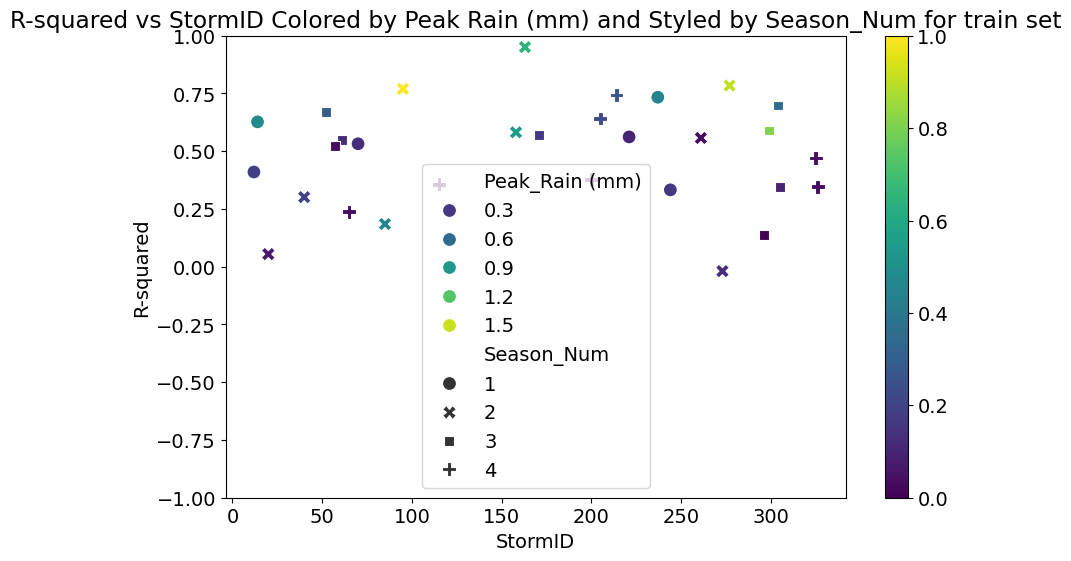

In [ ]:
# Modifying the scatter plot with larger point size

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for train set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-58-702129147f96>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


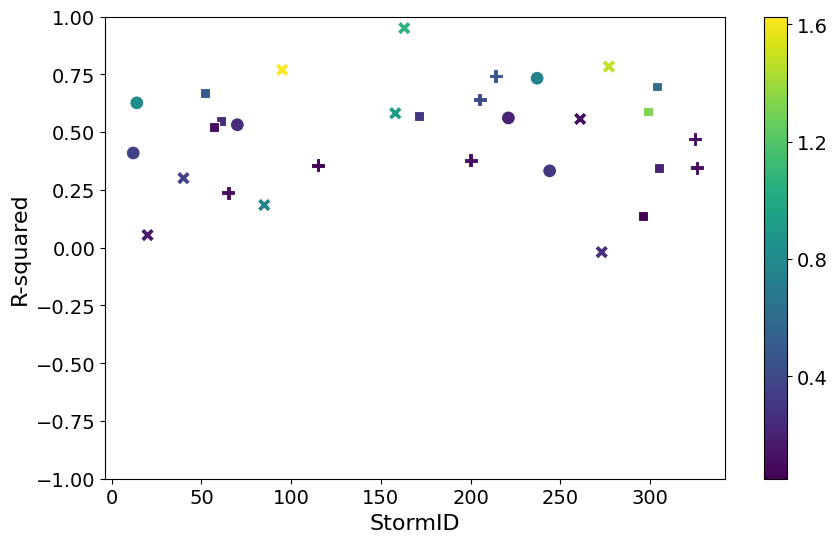

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_test['Peak_Rain (mm)'].min(), result_dataset_test['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

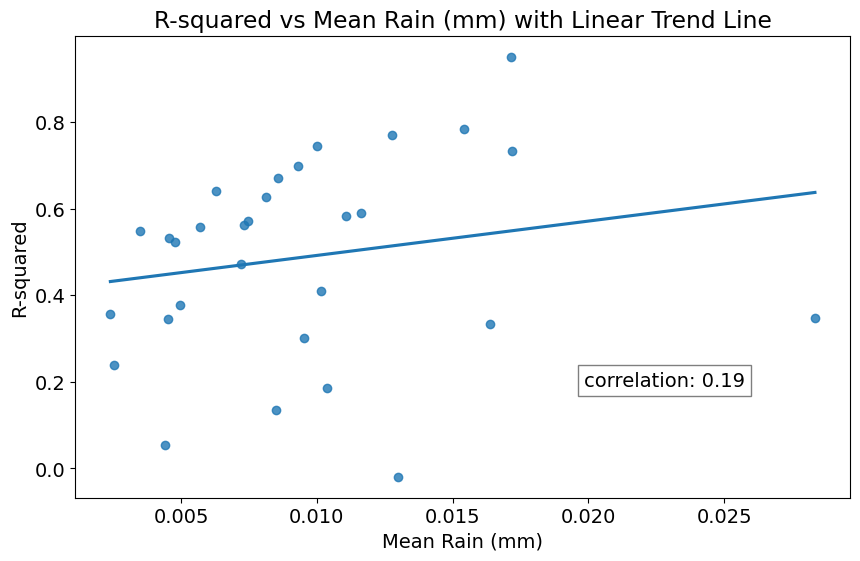

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_test, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

correlation = result_dataset_test['Mean_Rain (mm)'].corr(result_dataset_test['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_test['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_test['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

# Showing the plot
plt.show()

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,163.0,0.000037,0.950654,3.9116,1.0668,0.017156,2017,2
228,277.0,0.000158,0.784202,10.9728,1.4732,0.015411,2018,2
940,95.0,0.000346,0.769890,3.8608,1.6256,0.012784,2015,2
1242,214.0,0.000072,0.743961,4.7752,0.4572,0.010011,2018,4
1719,237.0,0.000076,0.733779,11.9888,0.7620,0.017176,2018,1
2417,304.0,0.000103,0.697990,5.9436,0.6096,0.009301,2018,3
3056,52.0,0.000045,0.670119,5.1308,0.5080,0.008580,2014,3
3654,205.0,0.000090,0.641773,3.0988,0.4064,0.006286,2018,4
4147,14.0,0.000162,0.627124,3.9624,0.8128,0.008120,2014,1
4635,299.0,0.000138,0.589359,16.3068,1.3208,0.011639,2018,3


In [ ]:
# Adding a new column to each dataset to indicate whether it's from train or test
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merging the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

In [ ]:
print(list(merged_dataset))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num', 'Type']


In [ ]:
# Determine thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms
def categorize_storm(rainfall):
    if rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply the function to categorize storms
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

merged_dataset

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num,Type,Storm_Category
0,125.0,0.000021,0.960595,1.5748,0.7112,0.011013,2017,1,train,small
1,147.0,0.000038,0.941609,8.7884,0.9652,0.024756,2017,2,train,large
2,263.0,0.000028,0.934331,13.8684,1.0160,0.019840,2018,2,train,large
3,153.0,0.000019,0.929078,1.7780,0.5080,0.008759,2017,2,train,small
4,139.0,0.000064,0.907586,3.0988,0.7620,0.013959,2017,2,train,medium
...,...,...,...,...,...,...,...,...,...,...
110,200.0,0.000033,0.300553,1.0160,0.1016,0.004956,2017,4,test,small
111,115.0,0.000017,0.289215,0.8636,0.0508,0.002399,2017,4,test,small
112,65.0,0.000020,0.170872,1.8796,0.1016,0.002540,2014,4,test,small
113,296.0,0.000027,0.156972,2.1844,0.0508,0.008500,2018,3,test,medium


In [ ]:
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

Trainset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_train.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.774138
medium    0.700816
small     0.496973
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.645713
2015    0.674202
2017    0.741381
2018    0.545299
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.650683
2    0.703797
3    0.627133
4    0.532977
Name: R-squared, dtype: float64


Testset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_test.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.583081
medium    0.471156
small     0.198912
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.473474
2015    0.501975
2017    0.389003
2018    0.447109
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.523980
2    0.331784
3    0.517313
4    0.413577
Name: R-squared, dtype: float64


#Temporal Range

In [ ]:
train_df

,Datetime,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),...,Mean_RR (mm/s),Max_RR (mm/s),Year,Month,Day,Season_Num,rain_indicator,hourly_rain,30min_rain,15min_rain
0,4/8/2014 0:05,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.0,0.0,0.0,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
1,4/8/2014 0:10,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.0,0.0,0.0,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
2,4/8/2014 0:15,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.0,0.0,0.0,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
3,4/8/2014 0:20,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.0,0.0,0.0,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
4,4/8/2014 0:25,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.0,0.0,0.0,...,-0.000508,0.00000,2014,4,8,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58072,12/24/2018 0:15,3.552,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0
58073,12/24/2018 0:20,3.483,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0
58074,12/24/2018 0:25,3.463,5.0840,0.386000,0.427000,0.452000,0.417000,0.0,0.0,0.0,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0
58075,12/24/2018 0:30,3.395,5.0814,0.386000,0.427000,0.452000,0.417000,0.0,0.0,0.0,...,0.000004,0.04064,2018,12,24,4,0,0.0,0.0,0.0


In [ ]:
# Make predictions on the train data
y_pred_train = model.predict(X_train_scaled)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 3.455016901393744e-05
R-squared: 0.7953416239310912


In [ ]:
train_df['y_pred_train'] = y_pred_train

<ipython-input-21-7324e8a8d739>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['y_pred_train'] = y_pred_train


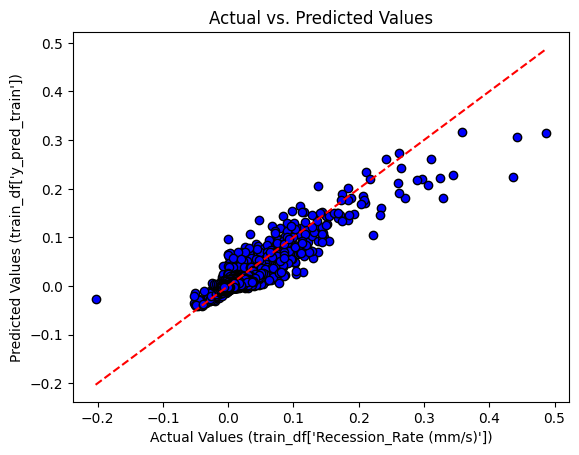

In [ ]:
# Create a scatter plot
plt.scatter(train_df['Recession_Rate (mm/s)'], train_df['y_pred_train'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (train_df['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (train_df['y_pred_train'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(train_df['Recession_Rate (mm/s)']), max(train_df['Recession_Rate (mm/s)'])], [min(train_df['Recession_Rate (mm/s)']), max(train_df['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_train, y_pred_train)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred_train)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 3.455016901393744e-05
Root Mean Squared Error (RMSE): 0.00587793918086411
Mean Absolute Error (MAE): 0.0032446619778705474
R-squared (R2) Score: 0.7953416239310912
Explained Variance Score (EVS): 0.7953416671915107


In [ ]:
# Group by 'StormID', then resample and sum
train_df_15mins = train_df.groupby('StormID').resample('15T').sum()
train_df_30mins = train_df.groupby('StormID').resample('30T').sum()
train_df_1hr = train_df.groupby('StormID').resample('1H').sum()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [ ]:
train_df_15mins

Temp_Air  Temp_Moist  Soil_MC_10  Soil_MC_35  \
StormID Datetime                                                            
2       2014-04-15 07:00:00    35.800     18.1686    0.664840    0.710712   
        2014-04-15 07:15:00    53.860     27.2546    0.999284    1.064045   
        2014-04-15 07:30:00    54.040     27.2640    0.999284    1.065394   
        2014-04-15 07:45:00    53.680     27.2648    0.999284    1.066743   
        2014-04-15 08:00:00    53.800     27.2806    1.000633    1.066743   
...                               ...         ...         ...         ...   
322     2018-12-23 23:30:00     9.907     15.3042    1.161000    1.281000   
        2018-12-23 23:45:00    10.188     15.2880    1.161000    1.281000   
        2018-12-24 00:00:00    11.039     15.2720    1.160000    1.281000   
        2018-12-24 00:15:00    10.498     15.2524    1.160000    1.281000   
        2018-12-24 00:30:00     6.716     10.1614    0.773000    0.855000   

                             Soil_MC_65  Soil_MC_91  Inflow (mm/s)  \
StormID Datetime                                                     
2       2014-04-15 07:00:00    0.623015    0.733649            0.0   
        2014-04-15 07:15:00    0.934522    1.100473            0.0   
        2014-04-15 07:30:00    0.931824    1.097775            0.0   
        2014-04-15 07:45:00    0.933173    1.097775            0.0   
        2014-04-15 08:00:00    0.937221    1.096425            0.0   
...                                 ...         ...            ...   
322     2018-12-23 23:30:00    1.356000    1.253000            0.0   
        2018-12-23 23:45:00    1.356000    1.252000            0.0   
        2018-12-24 00:00:00    1.356000    1.254000            0.0   
        2018-12-24 00:15:00    1.356000    1.253000            0.0   
        2018-12-24 00:30:00    0.904000    0.834000            0.0   

                             Overflow(mm/s)  Precipitation (mm)  \
StormID Datetime                                                  
2       2014-04-15 07:00:00             0.0                 0.0   
        2014-04-15 07:15:00             0.0                 0.0   
        2014-04-15 07:30:00             0.0                 0.0   
        2014-04-15 07:45:00             0.0                 0.0   
        2014-04-15 08:00:00             0.0                 0.0   
...                                     ...                 ...   
322     2018-12-23 23:30:00             0.0                 0.0   
        2018-12-23 23:45:00             0.0                 0.0   
        2018-12-24 00:00:00             0.0                 0.0   
        2018-12-24 00:15:00             0.0                 0.0   
        2018-12-24 00:30:00             0.0                 0.0   

                             Water_Depth (mm)  ...  Max_RR (mm/s)  Year  \
StormID Datetime                               ...                        
2       2014-04-15 07:00:00          249.9360  ...       0.885952  4028   
        2014-04-15 07:15:00          374.9040  ...       1.328928  6042   
        2014-04-15 07:30:00          374.9040  ...       1.328928  6042   
        2014-04-15 07:45:00          374.9040  ...       1.328928  6042   
        2014-04-15 08:00:00          374.9040  ...       1.328928  6042   
...                                       ...  ...            ...   ...   
322     2018-12-23 23:30:00          403.8600  ...       0.121920  6054   
        2018-12-23 23:45:00          395.3256  ...       0.121920  6054   
        2018-12-24 00:00:00          391.0584  ...       0.121920  6054   
        2018-12-24 00:15:00          384.0480  ...       0.121920  6054   
        2018-12-24 00:30:00          253.8984  ...       0.081280  4036   

                             Month  Day  Season_Num  rain_indicator  \
StormID Datetime                                                      
2       2014-04-15 07:00:00      8   30           2               0   
        2014-04-15 07:15:00     12   45           3    

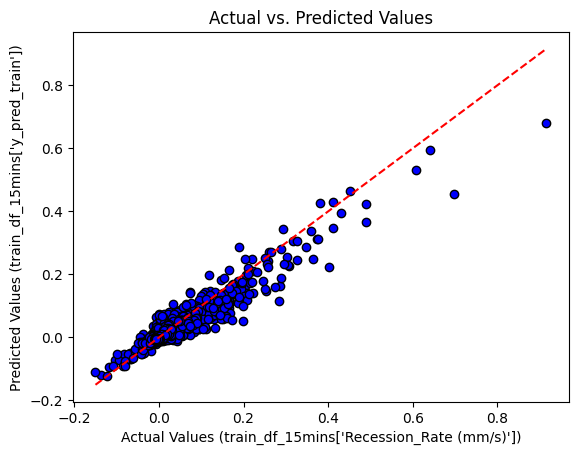

In [ ]:
# Create a scatter plot
plt.scatter(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (train_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (train_df_15mins['y_pred_train'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], [min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
print(list(train_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_train']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0001254399848685063
Root Mean Squared Error (RMSE): 0.011199999324486868
Mean Absolute Error (MAE): 0.005553733089065994
R-squared (R2) Score: 0.8879004850105975
Explained Variance Score (EVS): 0.8879005712813886


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002967376238299554
Root Mean Squared Error (RMSE): 0.01722607395287607
Mean Absolute Error (MAE): 0.00703032176172031
R-squared (R2) Score: 0.9012549728659561
Explained Variance Score (EVS): 0.9012550450809699


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007423040050424713
Root Mean Squared Error (RMSE): 0.027245256560408295
Mean Absolute Error (MAE): 0.0114651493271888
R-squared (R2) Score: 0.9128484418723348
Explained Variance Score (EVS): 0.9128485407917195


Test Score

In [ ]:
# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 5.5884745255876334e-05
R-squared: 0.6115942499573841


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred_test)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred_test)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 5.5884745255876334e-05
Root Mean Squared Error (RMSE): 0.007475610025668563
Mean Absolute Error (MAE): 0.0033791325517096775
R-squared (R2) Score: 0.6115942499573841
Explained Variance Score (EVS): 0.6115994736203476


In [ ]:
test_df['y_pred_test'] = y_pred_test

<ipython-input-82-ea87f587c1f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_pred_test'] = y_pred_test


In [ ]:
# Group by 'StormID', then resample and sum
test_df_15mins = test_df.groupby('StormID').resample('15T').sum()
test_df_30mins = test_df.groupby('StormID').resample('30T').sum()
test_df_1hr = test_df.groupby('StormID').resample('1H').sum()

In [ ]:
test_df_15mins

Temp_Air  Temp_Moist  Soil_MC_10  Soil_MC_35  \
StormID Datetime                                                            
12      2014-05-23 16:30:00    21.390     16.4940    0.295317    0.299365   
        2014-05-23 16:45:00    65.940     49.4900    0.885951    0.899443   
        2014-05-23 17:00:00    68.760     49.5060    0.885951    0.899443   
        2014-05-23 17:15:00    65.960     49.5300    0.884602    0.898094   
        2014-05-23 17:30:00    63.390     49.5540    0.884602    0.900792   
...                               ...         ...         ...         ...   
325     2018-12-31 04:00:00    -0.601     13.1198    0.490000    1.320000   
        2018-12-31 04:15:00    -1.428     13.1346    0.583000    1.320000   
        2018-12-31 04:30:00    -2.078     13.1360    0.794000    1.320000   
        2018-12-31 04:45:00    -2.768     13.1202    0.141000    1.319000   
        2018-12-31 05:00:00    -1.894      8.7562    0.175000    0.878000   

                             Soil_MC_65  Soil_MC_91  Inflow (mm/s)  \
StormID Datetime                                                     
12      2014-05-23 16:30:00    0.307460    0.365475            0.0   
        2014-05-23 16:45:00    0.925078    1.096425            0.0   
        2014-05-23 17:00:00    0.926427    1.097775            0.0   
        2014-05-23 17:15:00    0.923729    1.096425            0.0   
        2014-05-23 17:30:00    0.925078    1.097775            0.0   
...                                 ...         ...            ...   
325     2018-12-31 04:00:00    1.367000    1.243000            0.0   
        2018-12-31 04:15:00    1.367000    1.243000            0.0   
        2018-12-31 04:30:00    1.367000    1.242000            0.0   
        2018-12-31 04:45:00    1.366000    1.242000            0.0   
        2018-12-31 05:00:00    0.911000    0.828000            0.0   

                             Overflow(mm/s)  Precipitation (mm)  \
StormID Datetime                                                  
12      2014-05-23 16:30:00             0.0                 0.0   
        2014-05-23 16:45:00             0.0                 0.0   
        2014-05-23 17:00:00             0.0                 0.0   
        2014-05-23 17:15:00             0.0                 0.0   
        2014-05-23 17:30:00             0.0                 0.0   
...                                     ...                 ...   
325     2018-12-31 04:00:00             0.0                 0.0   
        2018-12-31 04:15:00             0.0                 0.0   
        2018-12-31 04:30:00             0.0                 0.0   
        2018-12-31 04:45:00             0.0                 0.0   
        2018-12-31 05:00:00             0.0                 0.0   

                             Water_Depth (mm)  ...  Max_RR (mm/s)  Year  \
StormID Datetime                               ...                        
12      2014-05-23 16:30:00          124.9680  ...       0.054864  2014   
        2014-05-23 16:45:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:00:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:15:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:30:00          374.9040  ...       0.164592  6042   
...                                       ...  ...            ...   ...   
325     2018-12-31 04:00:00          407.5176  ...       0.182880  6054   
        2018-12-31 04:15:00          402.3360  ...       0.182880  6054   
        2018-12-31 04:30:00          395.9352  ...       0.182880  6054   
        2018-12-31 04:45:00          388.0104  ...       0.182880  6054   
        2018-12-31 05:00:00          254.5080  ...       0.121920  4036   

                             Month  Day  Season_Num  rain_indicator  \
StormID Datetime                                                      
12      2014-05-23 16:30:00      5   23           1               0   
        2014-05-23 16:45:00     15   69           3    

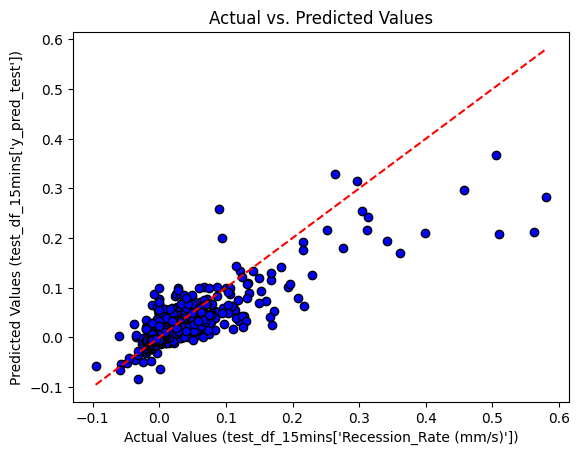

In [ ]:
# Create a scatter plot
plt.scatter(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (test_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (test_df_15mins['y_pred_test'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], [min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
print(list(test_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_test']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002577009716200089
Root Mean Squared Error (RMSE): 0.016053067358608102
Mean Absolute Error (MAE): 0.0067188533175421014
R-squared (R2) Score: 0.7146275783631919
Explained Variance Score (EVS): 0.7146349695000798


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007080910248096911
Root Mean Squared Error (RMSE): 0.026609979797243197
Mean Absolute Error (MAE): 0.010144665156752641
R-squared (R2) Score: 0.756020372694582
Explained Variance Score (EVS): 0.7560294833603853


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0018526832024212546
Root Mean Squared Error (RMSE): 0.043042806628068
Mean Absolute Error (MAE): 0.0171429865966911
R-squared (R2) Score: 0.7891346566868517
Explained Variance Score (EVS): 0.7891464457194693


#Model performance for year, season and storm size

In [ ]:
# Convert the predictions to a pandas Series and add them to the train_df
train_df['Predicted_Recession_Rate'] = pd.Series(y_pred_train.flatten(), index=train_df.index)

# Convert the predictions to a pandas Series and add them to the test_df
test_df['Predicted_Recession_Rate'] = pd.Series(y_pred_test.flatten(), index=test_df.index)

NameError: name 'y_pred_train' is not defined

In [ ]:
# Define the quantiles for storm size categories
quantiles = df['Accumulated_Rain (mm)'].quantile([0.33, 0.66])

# Function to categorize storm size
def categorize_storm_size(row):
    if row['Accumulated_Rain (mm)'] <= quantiles.iloc[0]:
        return 'Small'
    elif row['Accumulated_Rain (mm)'] <= quantiles.iloc[1]:
        return 'Medium'
    else:
        return 'Large'

# Apply the function to create a new column 'Storm_Size'
df['Storm_Size'] = df.apply(categorize_storm_size, axis=1)

In [ ]:
# Group by 'Storm_Size' and count unique 'StormID's in each group
storm_count_by_size = df.groupby('Storm_Size')['StormID'].nunique()

# Display the counts
print(storm_count_by_size)

Storm_Size
Large      22
Medium     35
Small     100
Name: StormID, dtype: int64


In [ ]:
# Group by 'Storm_Size' and calculate min and max of 'Accumulated_Rain (mm)' for each group
storm_size_ranges = df.groupby('Storm_Size')['Accumulated_Rain (mm)'].agg(['min', 'max'])

# Display the value ranges for each storm size
print(storm_size_ranges)

               min      max
Storm_Size                 
Large       6.8072  25.7048
Medium      3.2512   6.6548
Small       0.0000   3.2004


In [ ]:
# Define the quantiles for storm size categories
quantiles = test_df['Accumulated_Rain (mm)'].quantile([0.33, 0.66])

# Function to categorize storm size
def categorize_storm_size(row):
    if row['Accumulated_Rain (mm)'] <= quantiles.iloc[0]:
        return 'Small'
    elif row['Accumulated_Rain (mm)'] <= quantiles.iloc[1]:
        return 'Medium'
    else:
        return 'Large'

# Apply the function to create a new column 'Storm_Size'
test_df['Storm_Size'] = test_df.apply(categorize_storm_size, axis=1)

<ipython-input-29-0d8e3e2228ff>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Storm_Size'] = test_df.apply(categorize_storm_size, axis=1)


In [ ]:
# Group by 'Storm_Size' and count unique 'StormID's in each group
storm_count_by_size = test_df.groupby('Storm_Size')['StormID'].nunique()

# Display the counts
print(storm_count_by_size)

Storm_Size
Large      6
Medium     9
Small     16
Name: StormID, dtype: int64


In [ ]:
# Group by 'Storm_Size' and calculate min and max of 'Accumulated_Rain (mm)' for each group
storm_size_ranges = test_df.groupby('Storm_Size')['Accumulated_Rain (mm)'].agg(['min', 'max'])

# Display the value ranges for each storm size
print(storm_size_ranges)

               min      max
Storm_Size                 
Large       7.3152  16.3068
Medium      3.9116   6.6548
Small       0.8636   3.8608


In [ ]:
# Function to calculate R2 score for grouped data
def calculate_r2_for_grouped_data(df, group_column):
    unique_groups = df[group_column].unique()
    r2_scores = {}

    for group in unique_groups:
        # Filter data for the specific group
        group_df = df[df[group_column] == group]
        # Calculate R2 score for the group
        r2_score_group = r2_score(group_df['Recession_Rate (mm/s)'], group_df['Predicted_Recession_Rate'])
        r2_scores[group] = r2_score_group

    return r2_scores

# Calculate R2 score for each year in train and test data
r2_scores_train_year = calculate_r2_for_grouped_data(train_df, 'Year')
r2_scores_test_year = calculate_r2_for_grouped_data(test_df, 'Year')

# Calculate R2 score for each Season_Num in train and test data
r2_scores_train_Season_Num = calculate_r2_for_grouped_data(train_df, 'Season_Num')
r2_scores_test_Season_Num = calculate_r2_for_grouped_data(test_df, 'Season_Num')

# Print the results
print("R2 Scores by Year in Train Data:", r2_scores_train_year)
print("R2 Scores by Year in Test Data:", r2_scores_test_year)
print("R2 Scores by Season_Num in Train Data:", r2_scores_train_Season_Num)
print("R2 Scores by Season_Num in Test Data:", r2_scores_test_Season_Num)

R2 Scores by Year in Train Data: {2014: 0.8144375217873084, 2015: 0.8225793630210543, 2017: 0.8113846077340005, 2018: 0.7657038964048928}
R2 Scores by Year in Test Data: {2014: 0.36642019840329465, 2015: 0.6642237843999345, 2017: 0.7112916229468134, 2018: 0.6602473291589896}
R2 Scores by Season_Num in Train Data: {1: 0.8375984063291603, 2: 0.8279254167356372, 3: 0.6173174982672857, 4: 0.7170533296648436}
R2 Scores by Season_Num in Test Data: {1: 0.61907061380772, 2: 0.6144471533658493, 3: 0.6031627344996823, 4: 0.6058882419999636}


In [ ]:
# Function to calculate R2 score for each storm size category
def calculate_r2_for_storm_size(df):
    storm_sizes = df['Storm_Size'].unique()
    r2_scores = {}

    for size in storm_sizes:
        # Filter data for the specific storm size category
        size_df = df[df['Storm_Size'] == size]
        # Calculate R2 score for the category
        r2_score_size = r2_score(size_df['Recession_Rate (mm/s)'], size_df['Predicted_Recession_Rate'])
        r2_scores[size] = r2_score_size

    return r2_scores

# Calculate R2 score for each storm size category in train and test data
r2_scores_train_storm_size = calculate_r2_for_storm_size(train_df)
r2_scores_test_storm_size = calculate_r2_for_storm_size(test_df)

# Print the results
print("R2 Scores by Storm Size in Train Data:", r2_scores_train_storm_size)
print("R2 Scores by Storm Size in Test Data:", r2_scores_test_storm_size)

KeyError: 'Storm_Size'

In [ ]:
# Define the data for the dataframe
data_year = {
    'Year': [2014, 2015, 2017, 2018, 2014, 2015, 2017, 2018],
    'LR': [0.32, 0.63, 0.68, 0.55, 0.50, 0.42, 0.61, 0.47],
    'RF': [0.36, 0.66, 0.70, 0.66, 0.81, 0.82, 0.811, 0.76],
    'DDLSTM': [0.42, 0.44, 0.61, 0.53, 0.57, 0.65, 0.78, 0.61],  # Replace None with actual DDLSTM data
    'PILSTM': [0.38, 0.42, 0.66, 0.54, 0.59, 0.68, 0.82, 0.63],  # Replace None with actual PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Test', 'Train', 'Train', 'Train', 'Train']
}

# Create the dataframe
df_year = pd.DataFrame(data_year)

# Data from the image provided by the user
data_season = {
    'Season': [1, 2, 3, 4, 1, 2, 3, 4],
    'LR': [0.55, 0.56, 0.51, 0.48, 0.61, 0.50, 0.29, 0.44],
    'RF': [0.62, 0.61, 0.60, 0.60, 0.83, 0.82, 0.61, 0.72],
    'DDLSTM': [0.69, 0.67, 0.62, 0.63, 0.74, 0.76, 0.64, 0.80],  # Placeholder for missing DDLSTM data
    'PILSTM': [0.70, 0.71, 0.60, 0.64, 0.75, 0.78, 0.61, 0.79],  # Placeholder for missing PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Test', 'Train', 'Train', 'Train', 'Train']
}

# Create the DataFrame
df_season = pd.DataFrame(data_season)

# Data from the image provided by the user
data_storm_size = {
    'Storm Size': ['Large', 'Medium', 'Small', 'Large', 'Medium', 'Small'],
    'LR': [0.30, 0.32, 0.31, 0.36, 0.40, 0.43],
    'RF': [0.65, 0.68, 0.48, 0.80, 0.82, 0.74],
    'DDLSTM': [0.71, 0.78, 0.46, 0.81, 0.83, 0.82],  # Placeholder for missing DDLSTM data
    'PILSTM': [0.73, 0.80, 0.49, 0.81, 0.85, 0.87],  # Placeholder for missing PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Train', 'Train', 'Train']
}

# Create the DataFrame
df_storm_size = pd.DataFrame(data_storm_size)


# Define the complete data for the dataframe as provided by the user for the temporal resolution dataset
data_temporal_resolution = {
    'Temporal Resolution': [5, 15, 30, 60]*2,  # Two sets for Train and Test
    'LR': [0.51, 0.66, 0.73, 0.76, 0.44, 0.58, 0.82, -0.14],  # Train followed by Test
    'RF': [0.79, 0.87, 0.9, 0.91, 0.73, 0.72, 0.83, 0.23],  # Train followed by Test
    'DDLSTM': [0.87, 0.85, 0.87, 0.87, 0.82, 0.8, 0.93, 0.1],  # Train followed by Test
    'PILSTM': [0.9, 0.91, 0.91, 0.89, 0.86, 0.85, 0.95, 0.14],  # Train followed by Test
    'Sample': ['Train']*4 + ['Test']*4  # Identifying the sample type
}

# Create the dataframe with the temporal resolution data
df_temporal_resolution = pd.DataFrame(data_temporal_resolution)

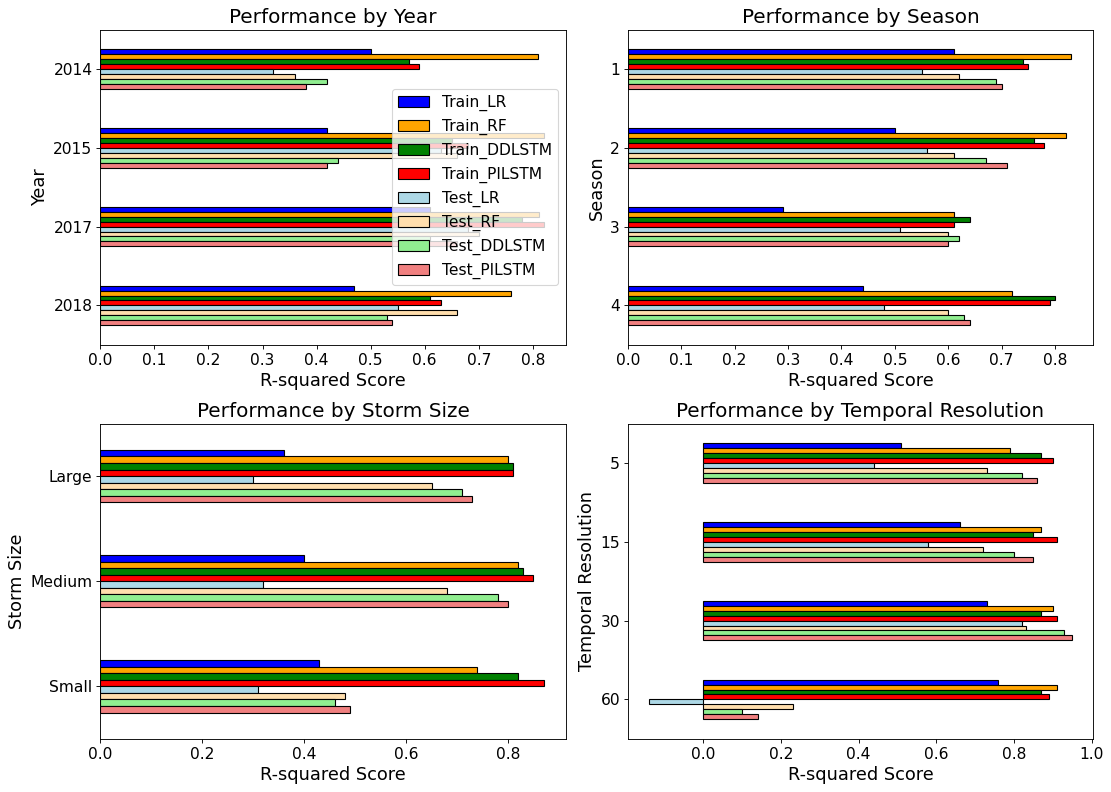

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_year, df_season, df_storm_size, df_temporal_resolution are defined
# ...

# Adjusting the plot to make Train and Test more distinct by using color shades
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), dpi=80)

# Titles for the subplots
titles = ['Performance by Year', 'Performance by Season', 'Performance by Storm Size', 'Performance by Temporal Resolution']

# DataFrames list
dataframes = [df_year, df_season, df_storm_size, df_temporal_resolution]

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Iterate over each subplot and dataframe
for i, (ax, title, df) in enumerate(zip(axes.flatten(), titles, dataframes)):
    # Split the dataframe into Test and Train
    df_test = df[df['Sample'] == 'Test'].drop(columns='Sample').set_index(df.columns[0])
    df_train = df[df['Sample'] == 'Train'].drop(columns='Sample').set_index(df.columns[0])

    # Concatenate Test and Train dataframes for side-by-side bars
    df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
    df_combined.columns = df_combined.columns.map('_'.join)

    # Plotting
    df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

    # Set titles, labels, and tick parameters with increased font sizes
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('R-squared Score', fontsize=16)
    ax.set_ylabel(df.columns[0], fontsize=16)  # Assuming the first column is the one to use for y-axis labels
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Invert y-axis to have the top bar represent the first row in the dataframe
    ax.invert_yaxis()

    # Set legend: Only for the first subplot, remove legend for others
    if i == 0:
        ax.legend(fontsize=14)
    else:
        ax.legend().remove()

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

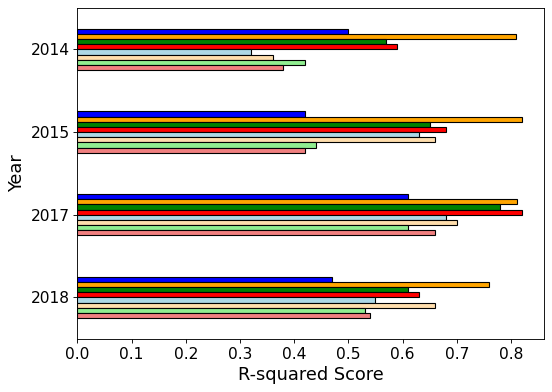

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_year is defined and structured with the first column as 'storm_size', followed by numeric columns 'LR', 'RF', 'DDLSTM', 'PILSTM', and 'Sample' as the last column

# Adjusting the plot to make Train and Test more distinct by using color shades
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)  # Adjust the size as needed

# Title for the subplot
# title = 'Performance by storm_size'

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Split the dataframe into Test and Train
df_test = df_year[df_year['Sample'] == 'Test'].drop(columns='Sample').set_index('Year')
df_train = df_year[df_year['Sample'] == 'Train'].drop(columns='Sample').set_index('Year')

# Concatenate Test and Train dataframes for side-by-side bars
df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
df_combined.columns = df_combined.columns.map('_'.join)

# Plotting
df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

# Set title, labels, and tick parameters with increased font sizes
# ax.set_title(title, fontsize=18)
ax.set_xlabel('R-squared Score', fontsize=16)
ax.set_ylabel('Year', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Invert y-axis to have the top bar represent the first row in the dataframe
ax.invert_yaxis()

# Remove the legend
ax.get_legend().remove()

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

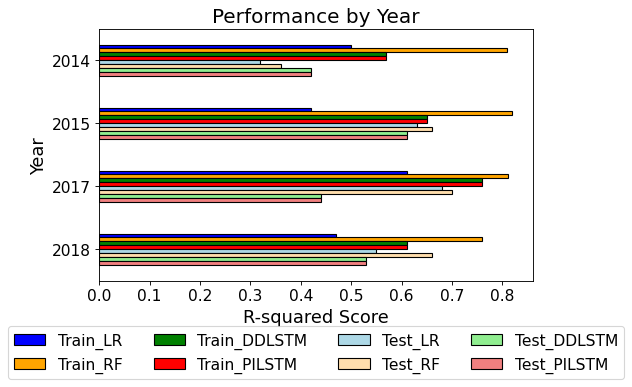

In [ ]:
# Adjusting the plot to make Train and Test more distinct by using color shades
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)  # Adjust the size as needed

# Title for the subplot
title = 'Performance by Year'

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Split the dataframe into Test and Train
df_test = df_year[df_year['Sample'] == 'Test'].drop(columns='Sample').set_index('Year')
df_train = df_year[df_year['Sample'] == 'Train'].drop(columns='Sample').set_index('Year')

# Concatenate Test and Train dataframes for side-by-side bars
df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
df_combined.columns = df_combined.columns.map('_'.join)

# Plotting
bars = df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

# Set title, labels, and tick parameters with increased font sizes
ax.set_title(title, fontsize=18)
ax.set_xlabel('R-squared Score', fontsize=16)
ax.set_ylabel('Year', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Invert y-axis to have the top bar represent the first row in the dataframe
ax.invert_yaxis()

# Place a legend below the plot, horizontally, with increased font size
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=14)  # Adjust fontsize as needed

# Adjust the bottom margin to make room for the legend
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom margin as needed

# Display the plot
plt.show()

#HP tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters and their possible values
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a Random Forest regressor
# rf_model = RandomForestRegressor(random_state=0)

# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Train the model with the best hyperparameters on the entire training set
# best_rf_model = RandomForestRegressor(**best_params, random_state=0)
# best_rf_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_validation_pred_tuned = best_rf_model.predict(X_validation)

# # Calculate performance metrics for the tuned model on the validation set
# mse_validation_tuned = mean_squared_error(y_validation, y_validation_pred_tuned)
# r2_validation_tuned = r2_score(y_validation, y_validation_pred_tuned)

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

# # Print the performance metrics for the tuned model on the validation set
# print("\nValidation Set Performance Metrics (Tuned Model):")
# print(f"Mean Squared Error (MSE): {mse_validation_tuned}")
# print(f"R-squared (R2): {r2_validation_tuned}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Validation Set Performance Metrics (Tuned Model):
Mean Squared Error (MSE): 1.8746396673424868e-08
R-squared (R2): 0.0


Check performance on test set after HP tuning

In [ ]:
#testing_data = filtered_df[filtered_df['StormID'].isin(range(num_training_storms + num_valid_storms + 1, num_training_storms + num_valid_storms + num_testing_storms + 1))]
X_test = testing_data[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Precipitation', 'Water_Depth', 'DryDays', 'accumulated_rain', 'peak_rain', 'mean_rain', 'peak_inflow', 'mean_inflow', 'Season_Num']]
y_test = testing_data['Recession_Rate']
# Make predictions on the testing data
y_pred_test = rf_model.predict(X_test)

# Calculate performance metrics
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

In [ ]:
# Print the performance metrics for the tuned model on the test set
print("\ntest Set Performance Metrics (Tuned Model):")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"R-squared (R2): {r2_test}")


test Set Performance Metrics (Tuned Model):
Mean Squared Error (MSE): 2.6830752335997112e-05
R-squared (R2): 0.697558618703572


In [ ]:
# Filter the data for the specific storm IDs you want to evaluate
specific_storm_ids = [249]

#specific_storm_ids = [253, 254, 255, 256, 257]

specific_storm_data = df[df['StormID'].isin(specific_storm_ids)]

# Define the input features and target variable
X_specific_storm = specific_storm_data[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Precipitation', 'Water_Depth', 'DryDays', 'accumulated_rain', 'peak_rain', 'mean_rain', 'peak_inflow', 'mean_inflow', 'Season_Num']]
y_specific_storm = specific_storm_data['Recession_Rate']

# Make predictions for the specific storms
y_pred_specific_storm = rf_model.predict(X_specific_storm)

# Calculate performance metrics
mse_specific_storm = mean_squared_error(y_specific_storm, y_pred_specific_storm)
r2_specific_storm = r2_score(y_specific_storm, y_pred_specific_storm)

# Print the performance metrics for the specific storms
print(f"Mean Squared Error (MSE) for specific storms: {mse_specific_storm}")
print(f"R-squared (R2) for specific storms: {r2_specific_storm}")

Mean Squared Error (MSE) for specific storms: 7.807308064451255e-05
R-squared (R2) for specific storms: 0.7129732811801563


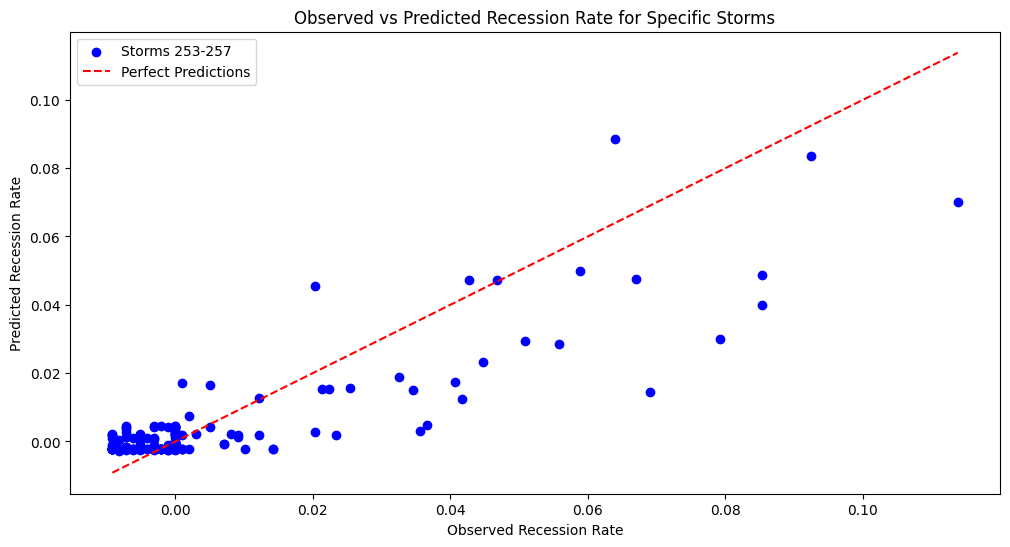

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of observed vs predicted values for each specific storm
plt.figure(figsize=(12, 6))
plt.title("Observed vs Predicted Recession Rate for Specific Storms")
plt.xlabel("Observed Recession Rate")
plt.ylabel("Predicted Recession Rate")

# Plot observed vs predicted values for each specific storm
plt.scatter(y_specific_storm, y_pred_specific_storm, label='Storms 253-257', color='blue', marker='o')

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_specific_storm), max(y_specific_storm)], [min(y_specific_storm), max(y_specific_storm)], linestyle='--', color='red', label='Perfect Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()

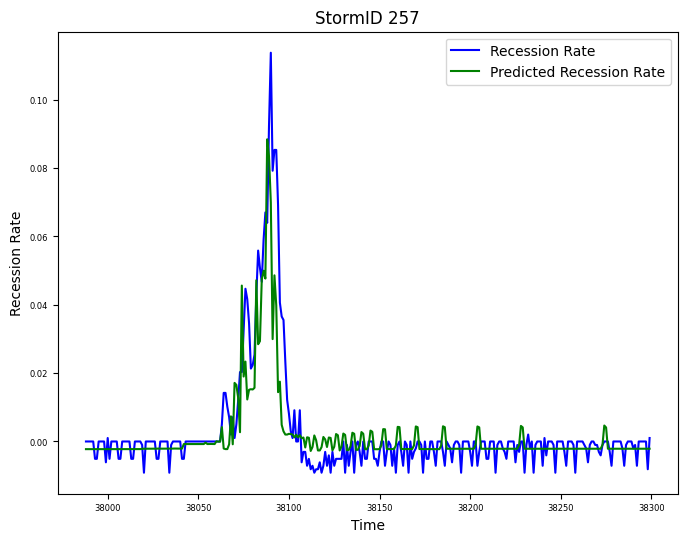

In [ ]:
# Create a plot for the specific storm
plt.figure(figsize=(8, 6))
plt.plot(specific_storm_data.index, specific_storm_data['Recession_Rate'], color='blue', label='Recession Rate')
plt.plot(specific_storm_data.index, y_pred_specific_storm, color='green', label='Predicted Recession Rate')
plt.xlabel('Time')
plt.ylabel('Recession Rate')
plt.title(f'StormID 257')
plt.legend()
plt.grid(False)

# Make x-ticks and y-ticks smaller
plt.tick_params(axis='both', which='both', labelsize=6)

# Show the plot
plt.show()

<Axes: >

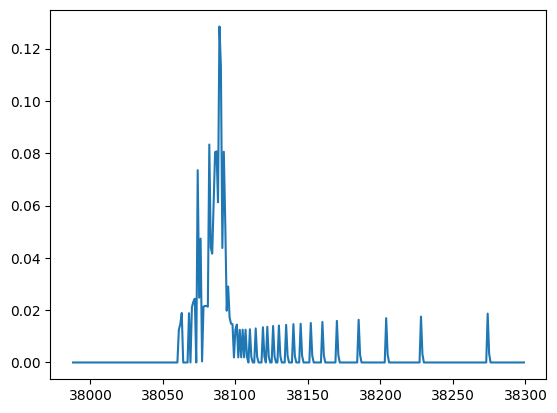

In [ ]:
specific_storm_data['Inflow'].plot()

#Model transfer variation in Inputs

In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


In [ ]:
# Split the dataset based on unique storm events
unique_storm_events = df['StormID'].unique()
train_storm_events = unique_storm_events[:124]
test_storm_events = unique_storm_events[124:]

In [ ]:
test_storm_events

array([250, 253, 254, 256, 259, 260, 261, 262, 263, 269, 270, 271, 272,
       273, 274, 277, 284, 290, 291, 294, 295, 296, 298, 299, 302, 304,
       305, 308, 312, 320, 322, 325, 326])

In [ ]:
input_columns = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']
#input_columns = ['Temp_Air', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']
#input_columns = ['Precipitation (mm)','Previous_Dry_Days', 'StormID']

target_column = 'Recession_Rate (mm/s)'

In [ ]:
# Split the data into train and test sets
train_df = df[df['StormID'].isin(train_storm_events)]
test_df = df[df['StormID'].isin(test_storm_events)]

In [ ]:
# Define input features and target variable for the train and test sets
X_train = train_df[input_columns]
y_train = train_df[target_column]

X_test = test_df[input_columns]
y_test = test_df[target_column]

In [ ]:
X_train

,Temp_Air,Temp_Moist,Soil_MC_10,Precipitation (mm),Previous_Dry_Days,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),StormID
0,9.81,5.1986,0.399205,0.0,0,0.4572,0.1016,0.005715,1
1,9.89,5.1946,0.396507,0.0,0,0.4572,0.1016,0.005715,1
2,9.91,5.1974,0.396507,0.0,0,0.4572,0.1016,0.005715,1
3,9.96,5.1998,0.395157,0.0,0,0.4572,0.1016,0.005715,1
4,9.98,5.2094,0.395157,0.0,0,0.4572,0.1016,0.005715,1
...,...,...,...,...,...,...,...,...,...
41333,16.41,15.8740,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41334,16.43,15.8760,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41335,16.50,15.8620,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41336,16.53,15.8620,0.382000,0.0,0,1.5240,0.3556,0.007471,249


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)  # You can adjust the number of estimators as needed
# Fit the model to the training data
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [ ]:
# Make predictions on the train data
y_pred = model.predict(X_train_scaled)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 8.990124159995783e-05
R-squared: 0.48483024438833655


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_train, y_pred)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 8.990124159995783e-05
Root Mean Squared Error (RMSE): 0.009481626527129078
Mean Absolute Error (MAE): 0.004111842159024027
R-squared (R2) Score: 0.48483024438833655
Explained Variance Score (EVS): 0.48483024646394135


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.00016130149209107327
R-squared: 0.19285846682714636


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.00016130149209107327
Root Mean Squared Error (RMSE): 0.012700452436471438
Mean Absolute Error (MAE): 0.0052377845124810425
R-squared (R2) Score: 0.19285846682714636
Explained Variance Score (EVS): 0.1953457649558208


# Feature Importance

In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor()

# Fit the model on your training data
rf_model.fit(X_train, y_train)

# Perform permutation importance
results = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

# Get sorted importances
sorted_importances_idx = results.importances_mean.argsort()

# Print the feature importances
print("Features sorted by their importance:")
print(np.array(input_columns)[sorted_importances_idx])

Features sorted by their importance:
['Previous_Dry_Days' 'Peak_Rain (mm)' 'Accumulated_Rain (mm)'
 'Overflow(mm/s)' 'StormID' 'Soil_MC_35' 'Soil_MC_10' 'Temp_Air'
 'Soil_MC_91' 'Temp_Moist' 'Mean_Rain (mm)' 'Soil_MC_65'
 'Precipitation (mm)' 'Inflow (mm/s)']


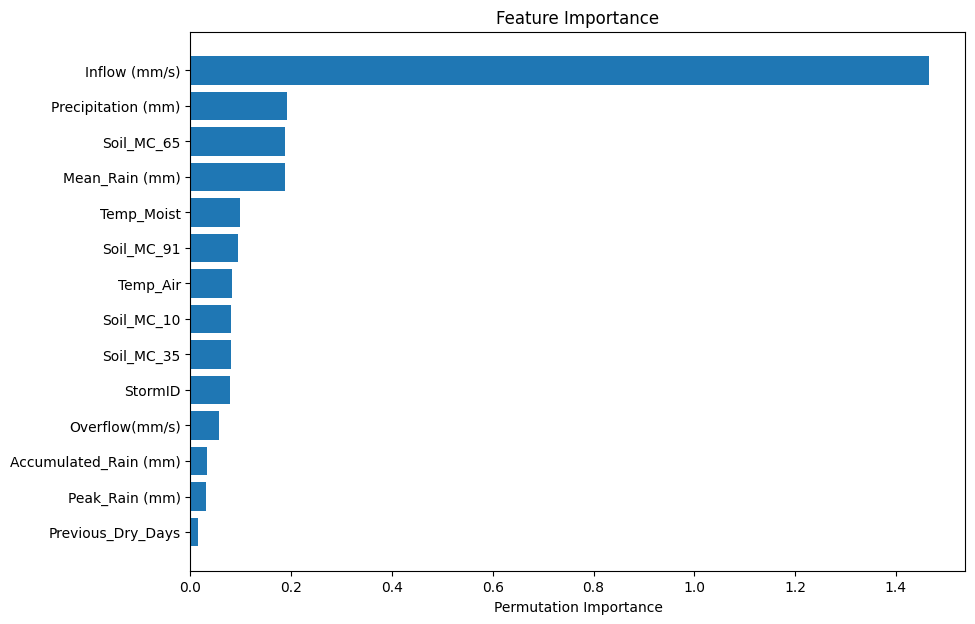

In [ ]:
import matplotlib.pyplot as plt

# Assuming `input_columns` is defined and matches the feature names in `X_train`
feature_names = np.array(input_columns)

# Sort the importances in descending order and get the indices
sorted_idx = results.importances_mean.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 7))
plt.barh(range(len(sorted_idx)), results.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor()

# Create the RFE model and select 5 attributes
rfe = RFE(estimator=rf_model, n_features_to_select=5)  # Adjust the number of features as needed

# Fit RFE
rfe.fit(X_train, y_train)

# Print the ranking of features
feature_ranking = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), input_columns))
print("Features sorted by their rank:")
print(feature_ranking)

Features sorted by their rank:
[(1, 'Inflow (mm/s)'), (1, 'Precipitation (mm)'), (1, 'Soil_MC_65'), (1, 'Temp_Air'), (1, 'Temp_Moist'), (2, 'Mean_Rain (mm)'), (3, 'Soil_MC_35'), (4, 'Soil_MC_91'), (5, 'Overflow(mm/s)'), (6, 'Soil_MC_10'), (7, 'Peak_Rain (mm)'), (8, 'Accumulated_Rain (mm)'), (9, 'StormID'), (10, 'Previous_Dry_Days')]


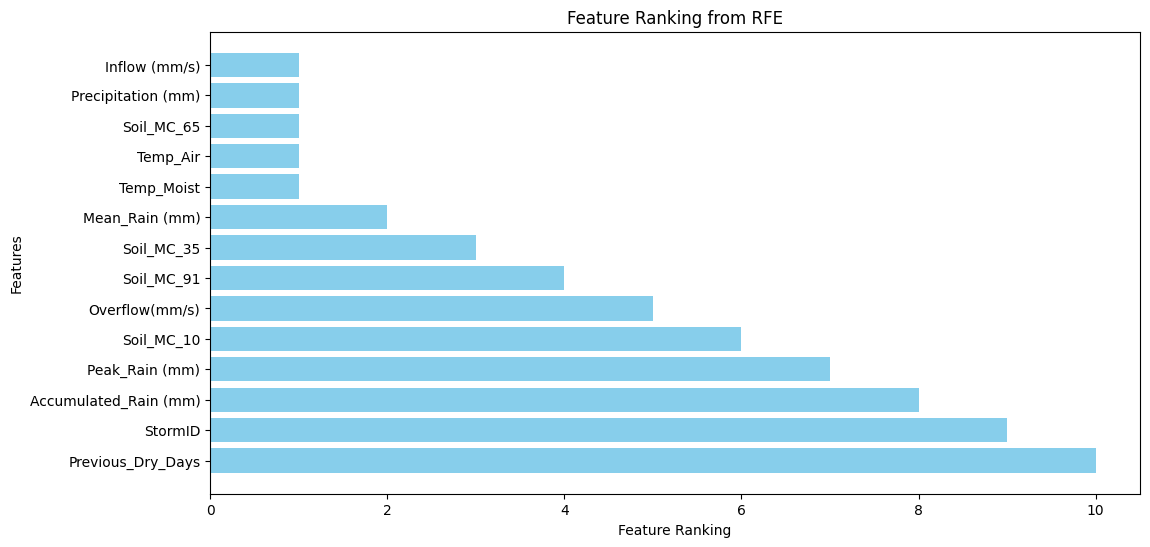

In [ ]:
import matplotlib.pyplot as plt

# Unzipping the rankings and feature names
rankings, features = zip(*feature_ranking)

# Creating a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking from RFE')
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top
plt.show()

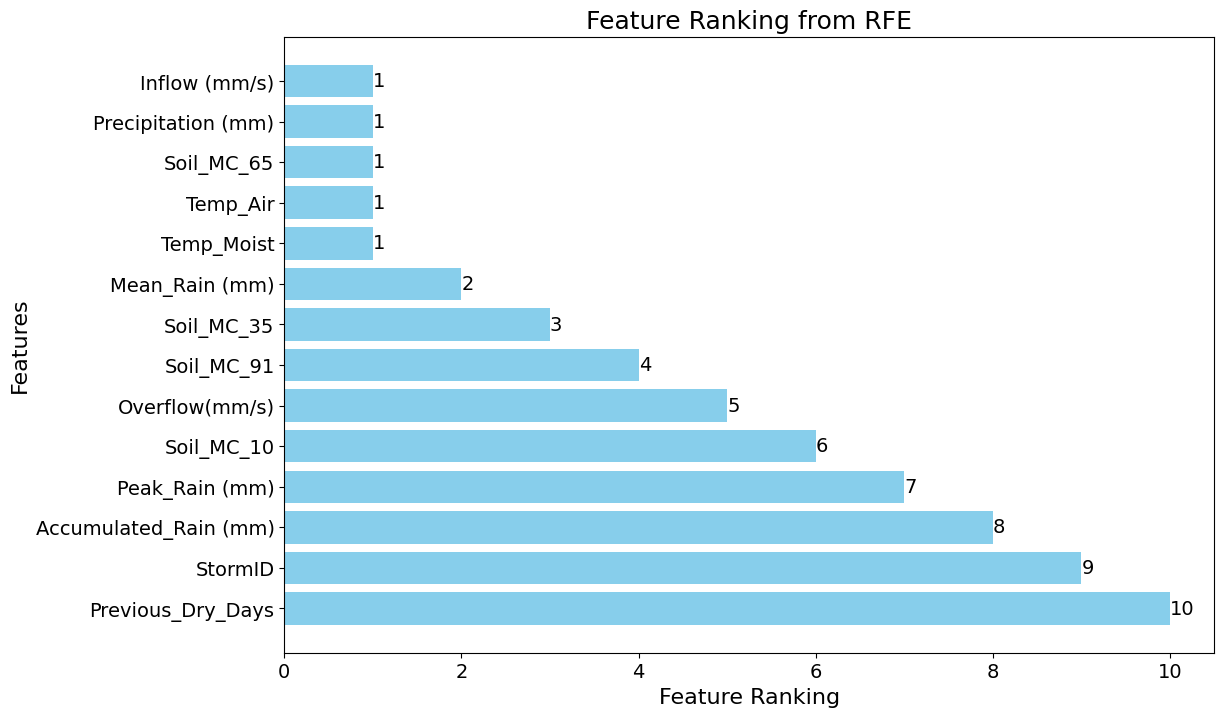

In [ ]:
import matplotlib.pyplot as plt

# Assuming feature_ranking is defined
# rankings, features = zip(*feature_ranking)

# Set global font size
plt.rcParams.update({'font.size': 14})  # Adjust as needed

# Creating a horizontal bar chart
plt.figure(figsize=(12, 8))  # Adjust size as needed
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('Features', fontsize=16)  # Adjust fontsize as needed
plt.title('Feature Ranking from RFE', fontsize=18)  # Adjust fontsize as needed
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=14)  # Adjust fontsize as needed

plt.show()

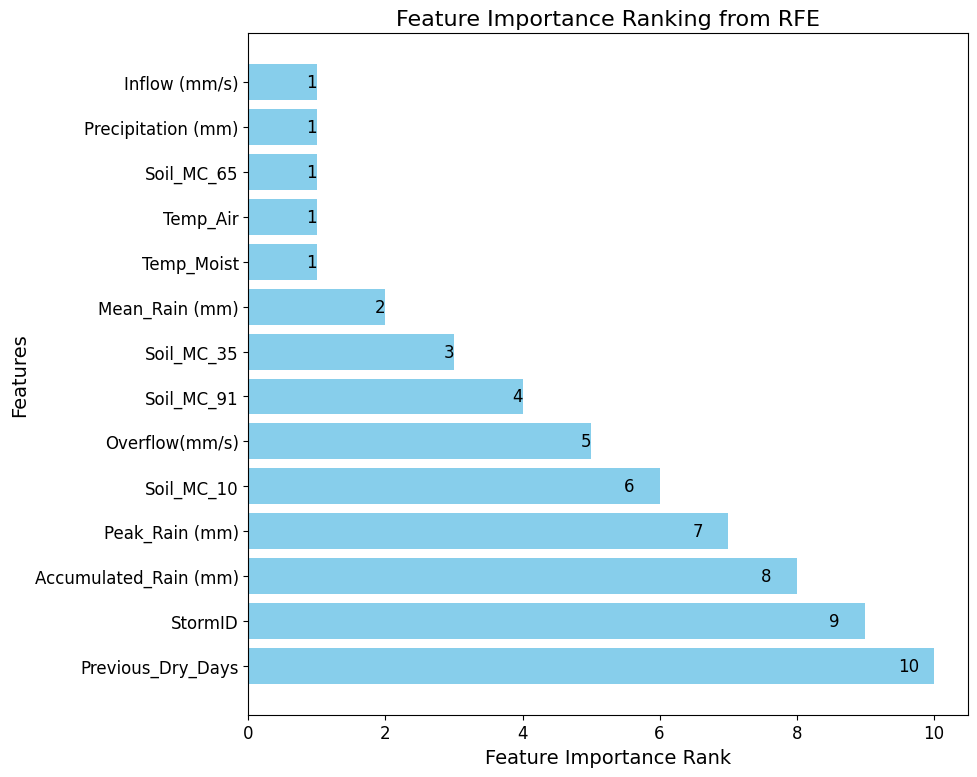

In [ ]:
# Unzipping the rankings and feature names
rankings, features = zip(*feature_ranking)

# Creating a horizontal bar chart for feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Importance Rank', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance Ranking from RFE', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width < plt.xlim()[1] * 0.5 else width - (plt.xlim()[1] * 0.05)
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2., f'{width}', va='center', ha='right' if width < plt.xlim()[1] * 0.5 else 'left', color='black', fontsize=12)

plt.tight_layout()
plt.show()

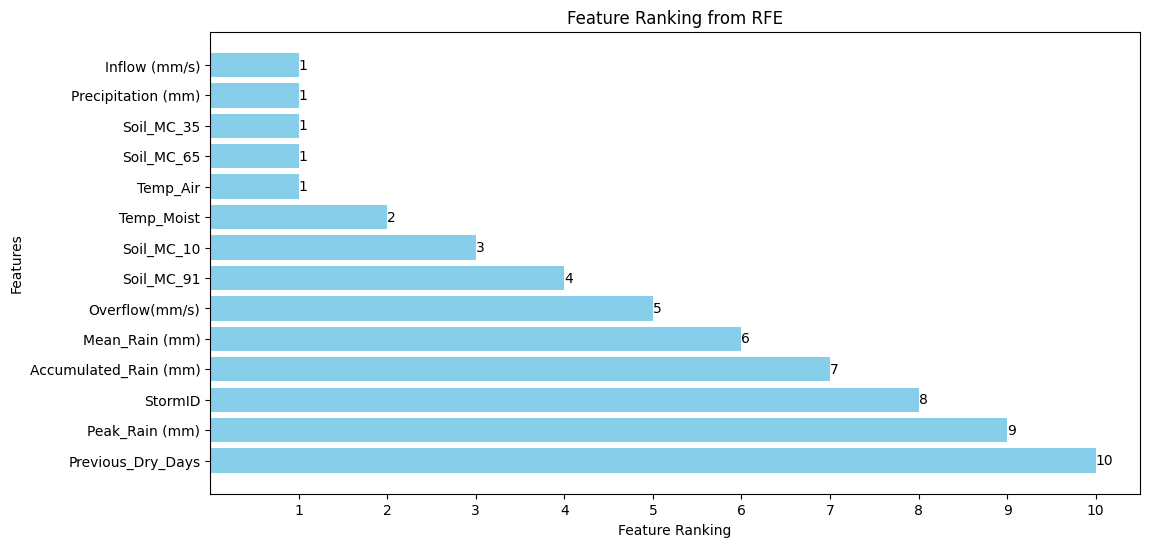

In [ ]:
# Correcting the code to display all x-tick values

plt.figure(figsize=(12, 6))
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking from RFE')
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center')

# Converting rankings to numeric values and setting x-ticks
numeric_rankings = [int(r) for r in rankings]
plt.xticks(range(1, max(numeric_rankings) + 1))

plt.show()

In [ ]:
rankings

(1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.inspection import permutation_importance

# # Assuming you have a trained model named 'model' and data 'X_test', 'y_test'

# # Compute Permutation Feature Importance
# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30)

# # Sort the features by importance
# sorted_idx = perm_importance.importances_mean.argsort()

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(input_columns)[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.title("Permutation Feature Importance")
# plt.show()

In [ ]:
!pip install scikit-learn

In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
print(list(X_train))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Initialize and fit the Gradient Boosting model
my_model = RandomForestRegressor()
my_model.fit(X_train, y_train)

TypeError: validate_params() got an unexpected keyword argument 'prefer_skip_nested_validation'

NameError: name 'PartialDependenceDisplay' is not defined

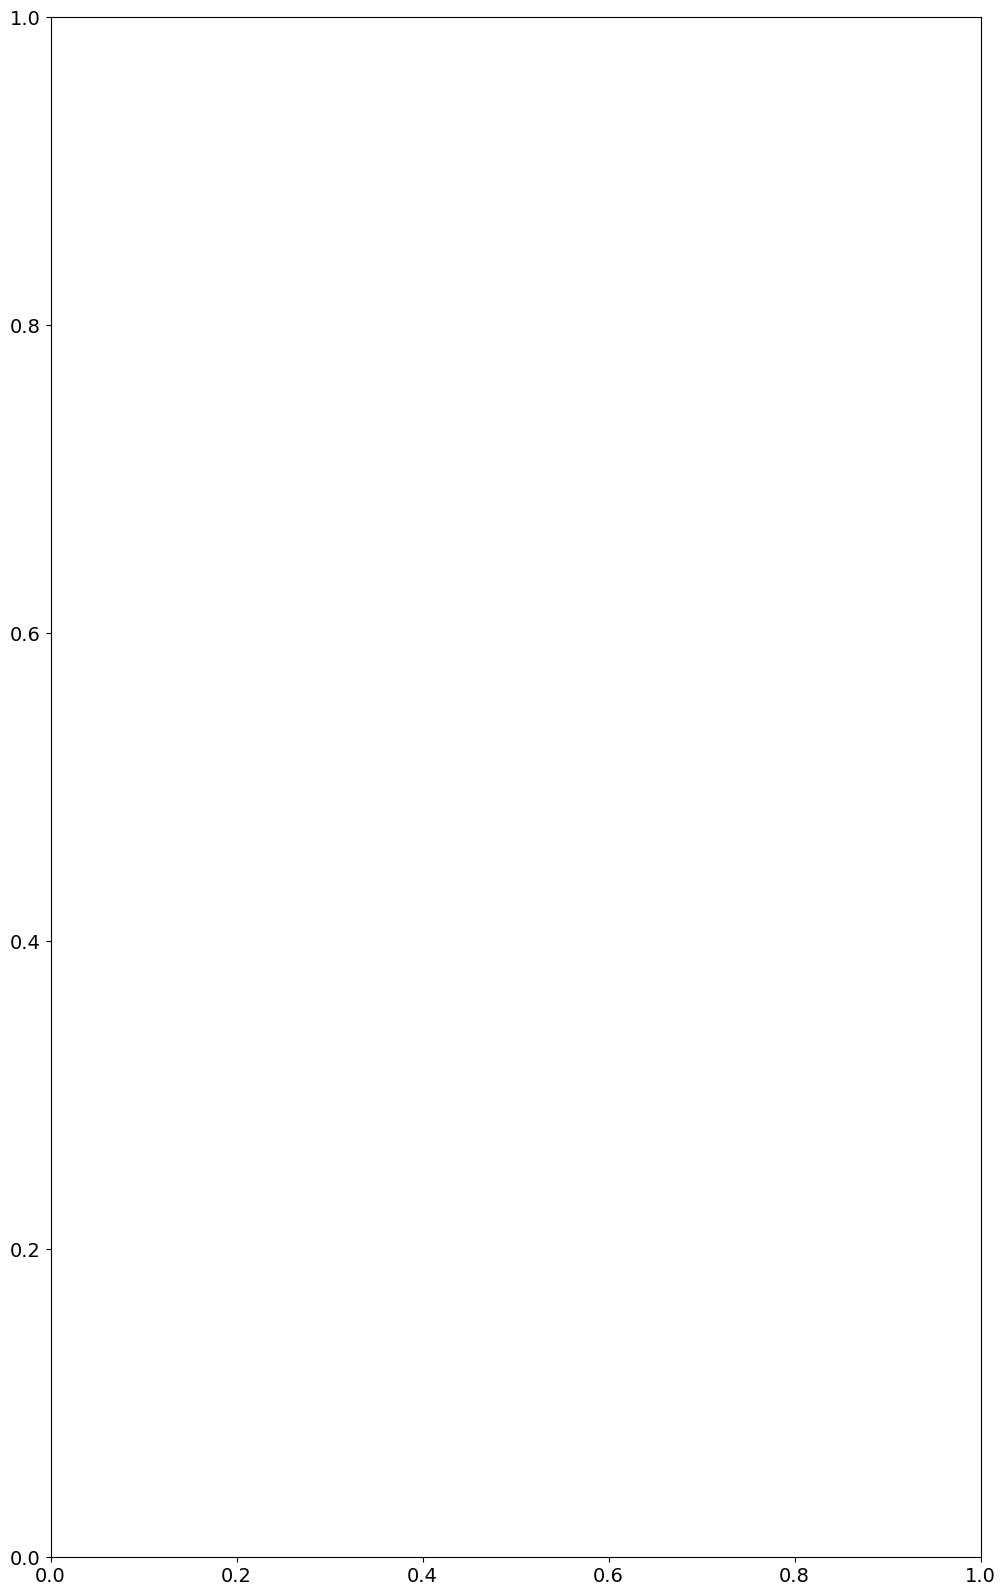

In [ ]:
# # Create Partial Dependence Plots
# fig, ax = plt.subplots(figsize=(12, 4))
# PartialDependenceDisplay.from_estimator(my_model, X_train, [1:8],
#                                         feature_names=['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)'],
#                                         grid_resolution=10, ax=ax)
# plt.show()

feature_indices = list(range(1, 12))  # This will select features 1 through 7

fig, ax = plt.subplots(figsize=(12, 20))
PartialDependenceDisplay.from_estimator(
    my_model, X_train, feature_indices,
    feature_names=['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)'],
    grid_resolution=10, ax=ax
)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Increase font sizes
plt.rcParams['font.size'] = 12  # Adjust as needed
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_indices = list(range(1, 12))  # This will select features 1 through 11
feature_names = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)']

fig, ax = plt.subplots(figsize=(12, 20))

# Customize the plot with a style context
with plt.style.context('ggplot'):  # You can change 'ggplot' to 'seaborn' or another style
    display = PartialDependenceDisplay.from_estimator(
        my_model, X_train, feature_indices,
        feature_names=feature_names,
        grid_resolution=10, ax=ax, n_jobs=3
    )
    display.figure_.suptitle('Partial Dependence of Features', fontweight='bold')
    display.figure_.subplots_adjust(top=0.9)  # Adjust the title position
    ax.set_ylabel('Partial Dependence (dPD)')

    # Set y-axis limits
    #ax.set_ylim(-0.003, 0.01)

    plt.show()


TypeError: validate_params() got an unexpected keyword argument 'prefer_skip_nested_validation'

In [ ]:
# Assuming model is your trained model and X is your feature DataFrame
features = input_columns  # You can select specific features as well

# Create the partial dependence plots
fig, ax = plt.subplots(figsize=(15, 10))
plot_partial_dependence(model, X, features, ax=ax, n_jobs=3, grid_resolution=20)

# Customize the plots
ax.set_title('Partial Dependence Plots')
plt.tight_layout()
plt.show()